# Multivariate Time Series Prediction Using Transformers Architecture

The following Notebook shows the coding part of my Bachelor Thesis for the Information and Communication Systems and Services bachelor degree in the University of Applied Science Technikum Wien.

Author: Sergio Tallo Torres
Date: April 2022

# First: load imports needed for the project and project preparation

In [2]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 282 (delta 28), reused 6 (delta 1), pack-reused 226
Receiving objects: 100% (282/282), 12.82 MiB | 22.92 MiB/s, done.
Resolving deltas: 100% (167/167), done.
/content/Bsc_Thesis
/content


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import math
from torch import Tensor, float32, sin, cos
import torch.nn as nn
import matplotlib.pyplot as plt
import utils_bsc
import datetime
import statistics
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from scipy import stats
from sklearn.decomposition import PCA

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla T4


In [4]:
utils_bsc.print_versions()

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.6
PyTorch: 1.11.0+cu113
Sklearn: 1.0.2
seaborn: 0.11.2


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [5]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the value of the previous elemnt in the sequence).

In [6]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [7]:
print_data = False

if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [8]:
# Set to True to print the graphs

print_graphs = False

if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [9]:
# We print some graphs showing the density distribution of every feature

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [10]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [11]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [12]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very different. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [13]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_norm.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [14]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 811.73it/s]


In [15]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1343.42it/s]


In [16]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 994.95it/s]


In [17]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [18]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [19]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

Covariance matrix of all features

(63360, 18)
<class 'numpy.float64'>


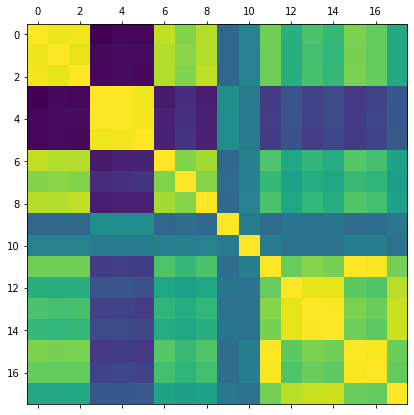

[9.572 2.940 1.352 0.989 0.970 0.891 0.405 0.251 0.230 0.177 0.072 0.052
 0.039 0.031 0.012 0.004 0.004 0.007]
[0.5317647804810274, 0.16335739298653476, 0.07511546472382995, 0.054921627068028424, 0.05390616867076577, 0.04952232661739343, 0.022486349463995598, 0.013932731902136385, 0.012792662672300325, 0.009829012007199104, 0.004024926426955747, 0.002893959610103366, 0.002163271201445878, 0.001741116222641519, 0.0006928432299862775, 0.00021826337426103455, 0.00023351820917083064, 0.0004035851322244031]


In [20]:
import matplotlib.pyplot as plt

set_ = dataset_norm.iloc[:,1:].values

print(set_.shape)
print(type(set_[0][0]))

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cov_matrix = np.cov(set_.T)

fig = plt.figure(figsize=(15, 15))

# Adds subplot on position 1
ax = fig.add_subplot(121)
ax.matshow(cov_matrix)
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print(eigenvalues)

explained_variance = []

for i in eigenvalues:
    explained_variance.append(i/sum(eigenvalues))

print(explained_variance)

# Correlation between features

In [21]:
correlations = []
matrix = []

for i in dataset_norm.columns[1:]:
  feature = []
  for j in dataset_norm.columns[1:]:
    print(f'Correlation between {i} and {j}')
    correlation = stats.pearsonr(dataset_norm[i], dataset_norm[j])[0]
    if i != j:
      correlations.append(abs(correlation))
      feature.append(abs(correlation))
      print(correlation)
  print(f'Mean of {i} correlations: {np.mean(feature)}')
  print('')
  matrix.append(feature)

print(f'Mean of all correlations: {np.mean(correlations)}')

Correlation between PLN1 and PLN1
Correlation between PLN1 and PLN2
0.9530638927686162
Correlation between PLN1 and PLN3
0.9606664987977854
Correlation between PLN1 and ULL1
-0.7274016376341781
Correlation between PLN1 and ULL2
-0.6955282277514699
Correlation between PLN1 and ULL3
-0.7030835410050383
Correlation between PLN1 and COS_PHI1
0.8410401295195358
Correlation between PLN1 and COS_PHI2
0.6731338062873106
Correlation between PLN1 and COS_PHI3
0.8122370309192151
Correlation between PLN1 and FREQ
-0.1545159794969927
Correlation between PLN1 and RC_DC
0.04144790238090616
Correlation between PLN1 and RC_AC
0.6311099014117806
Correlation between PLN1 and RC_50Hz
0.3688113546135111
Correlation between PLN1 and RC_150Hz
0.5078743784519382
Correlation between PLN1 and RC_<100Hz
0.43093253308676593
Correlation between PLN1 and RC_100Hz-1kHz
0.6585953463453893
Correlation between PLN1 and RC_>1kHz
0.5928797475823843
Correlation between PLN1 and RC_>10kHz
0.3161918341465538
Mean of PLN1 co

In [22]:
# Covariance matrix, eigenvalues and explained variance

covmatrix = dataset_norm.cov()
eigenvalues, eigenvectors = np.linalg.eig(covmatrix)

acc = 0

for i, eigen in enumerate(eigenvalues):
  acc += eigen/np.sum(eigenvalues)
  print(f'Explained_variance {i +1} principal component: {eigen/np.sum(eigenvalues)} (accumulated {round(acc, 4)})')

Explained_variance 1 principal component: 0.5317647804810274 (accumulated 0.5318)
Explained_variance 2 principal component: 0.16335739298653476 (accumulated 0.6951)
Explained_variance 3 principal component: 0.07511546472382995 (accumulated 0.7702)
Explained_variance 4 principal component: 0.054921627068028424 (accumulated 0.8252)
Explained_variance 5 principal component: 0.05390616867076577 (accumulated 0.8791)
Explained_variance 6 principal component: 0.04952232661739343 (accumulated 0.9286)
Explained_variance 7 principal component: 0.022486349463995598 (accumulated 0.9511)
Explained_variance 8 principal component: 0.013932731902136385 (accumulated 0.965)
Explained_variance 9 principal component: 0.012792662672300325 (accumulated 0.9778)
Explained_variance 10 principal component: 0.009829012007199104 (accumulated 0.9876)
Explained_variance 11 principal component: 0.004024926426955747 (accumulated 0.9917)
Explained_variance 12 principal component: 0.002893959610103366 (accumulated 0.99

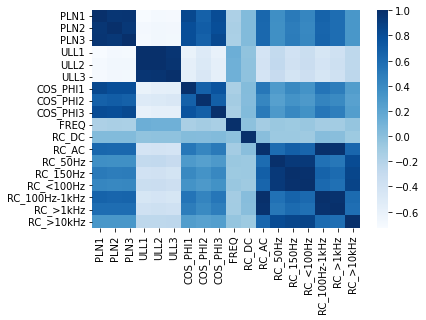

In [23]:
# Features correlations heat map

corr = dataset_norm.corr()
sns.heatmap(corr, cmap="Blues")

# Data loaders for the training

In [24]:
def create_sequece_dataloaders_new(dataset_norm):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of 30 measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 31)):    
    data = np.array(dataset_norm.iloc[i:i+30, 1:])
    next = np.array(dataset_norm.iloc[i+30, 1:], dtype= float)
    target = np.array(dataset_norm.iloc[i+31, 1:], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=16,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=16,
      shuffle=True
  )

  return loader_train, loader_test

In [25]:
loader_train_seq, loader_test_seq = create_sequece_dataloaders_new(dataset_norm)

100%|██████████| 63329/63329 [00:40<00:00, 1579.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56996
length of test set (whole dataset): 6333




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [25]:
def create_dataloaders_new(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
  # When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) -1)):
    data = np.array([j for j in dataset_norm.iloc[i, 1:]])
    target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=16,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=16,
      shuffle=True
  )

  return loader_train, loader_test

In [26]:
loader_train, loader_test = create_dataloaders_new(dataset_norm)

100%|██████████| 63359/63359 [00:20<00:00, 3113.76it/s]


length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




In [36]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

# save to npy file
if False:
  np.save('baseline_train.npy', losses_train)
  np.save('baseline_test.npy', losses_test)

Training set
Mean Loss of baselinemodel:  0.47263242820054124
Standard deviation Loss of baselinemodel:  0.17774659731197265


Test set
Mean Loss of baselinemodel:  0.47636275168395403
Standard deviation Loss of baselinemodel:  0.18142434392159165




In [28]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 640)
        self.linear3 = nn.Linear(640, 180)
        self.linear4 = nn.Linear(180, D_out)

        self.relu = torch.nn.ReLU()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)

        return self.linear4(x)

# This function trains the model for one epoch
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs):

    epoch_loss_train = []
    epoch_loss_test = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      print('Train')
      model.train()

      for i in tqdm(train_loader):

        data, target = i[0], i[1]

        optimizer.zero_grad()

        # Forward Pass
        output = model(data)

        #Compute loss
        loss = criterion(output, target)

        #Backpropagation
        loss.backward()

        #Optimization
        optimizer.step()

      losses = []

      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(train_loader):

          data, target = i[0], i[1]

          output = model(data)
              
          losses.append (float(criterion(output, target).item()))

      print('\nCurrent Mean loss Train: ', np.mean(losses))
      epoch_loss_train.append(losses)

      losses = []

      print('\nTest with test set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(test_loader):

          data, target = i[0], i[1]

          output = model(data)
            
          losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss_test.append(losses)

    return model, epoch_loss_train, epoch_loss_test

In [39]:
n_epochs = 200
lr=0.01

# Create model FFN instance
model_FFN = ANN_relu(18, 18).to(device)
print(model_FFN_whole)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_whole = torch.optim.SGD(model_FFN.parameters(), lr=lr)


train_FFN = True

params_not_trained_whole = model_FFN.parameters()

start_time = datetime.now()
if train_FFN is True:
  trained_model_FFN , train_losses_FFN, test_losses_FFN = train(model_FFN, criterion, optimizer_whole, loader_train, loader_test, n_epochs)

end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'\nTraining time: {execution_time} seconds')

# save to npy file
if True:
  np.save('FFN_train.npy', losses_train)
  np.save('FFN_test.npy', losses_test)

ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 1:
Train


100%|██████████| 3564/3564 [00:04<00:00, 747.17it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2217.45it/s]



Current Mean loss Train:  0.3303875571407386

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2295.31it/s]



Current Mean loss:  0.32939304765125715

Epoch 2:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.22it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2263.57it/s]



Current Mean loss Train:  0.31253679914297544

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2285.09it/s]



Current Mean loss:  0.31121633395627896

Epoch 3:
Train


100%|██████████| 3564/3564 [00:04<00:00, 741.86it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2275.89it/s]



Current Mean loss Train:  0.30549979448009085

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2292.72it/s]



Current Mean loss:  0.3042238202284683

Epoch 4:
Train


100%|██████████| 3564/3564 [00:04<00:00, 769.76it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2284.70it/s]



Current Mean loss Train:  0.30388420349453166

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2241.97it/s]



Current Mean loss:  0.3026165609069244

Epoch 5:
Train


100%|██████████| 3564/3564 [00:04<00:00, 758.23it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2276.47it/s]



Current Mean loss Train:  0.3016312786688407

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2260.82it/s]



Current Mean loss:  0.30022666590156577

Epoch 6:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.20it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2280.20it/s]



Current Mean loss Train:  0.30011563070795755

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2271.85it/s]



Current Mean loss:  0.2985043978751308

Epoch 7:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.75it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2239.33it/s]



Current Mean loss Train:  0.29972267511492023

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2252.81it/s]



Current Mean loss:  0.2985723118928045

Epoch 8:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.35it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2226.39it/s]



Current Mean loss Train:  0.298895961292481

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2280.57it/s]



Current Mean loss:  0.2980069194101926

Epoch 9:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.14it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2278.03it/s]



Current Mean loss Train:  0.297861106175298

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2291.67it/s]



Current Mean loss:  0.29651927123918675

Epoch 10:
Train


100%|██████████| 3564/3564 [00:04<00:00, 748.20it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2254.64it/s]



Current Mean loss Train:  0.29740693473270713

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2286.36it/s]



Current Mean loss:  0.29615186147316536

Epoch 11:
Train


100%|██████████| 3564/3564 [00:04<00:00, 770.93it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2249.55it/s]



Current Mean loss Train:  0.2966586642811863

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2181.42it/s]



Current Mean loss:  0.29539035992565177

Epoch 12:
Train


100%|██████████| 3564/3564 [00:04<00:00, 772.26it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2274.67it/s]



Current Mean loss Train:  0.296097674763497

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2301.19it/s]



Current Mean loss:  0.29492846086169733

Epoch 13:
Train


100%|██████████| 3564/3564 [00:04<00:00, 770.51it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2264.10it/s]



Current Mean loss Train:  0.29576552980584664

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2266.46it/s]



Current Mean loss:  0.29457159140946887

Epoch 14:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.28it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2266.51it/s]



Current Mean loss Train:  0.29515371998870277

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2293.42it/s]



Current Mean loss:  0.2940291804120396

Epoch 15:
Train


100%|██████████| 3564/3564 [00:04<00:00, 757.42it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2307.86it/s]



Current Mean loss Train:  0.29497033897181085

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2290.42it/s]



Current Mean loss:  0.29405038350384044

Epoch 16:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.25it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2289.77it/s]



Current Mean loss Train:  0.294577911519158

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2248.31it/s]



Current Mean loss:  0.2937843399404576

Epoch 17:
Train


100%|██████████| 3564/3564 [00:04<00:00, 772.76it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2283.14it/s]



Current Mean loss Train:  0.294117892988854

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2241.12it/s]



Current Mean loss:  0.29317782160760175

Epoch 18:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.23it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2272.23it/s]



Current Mean loss Train:  0.2940360339824633

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2287.86it/s]



Current Mean loss:  0.2933064994562154

Epoch 19:
Train


100%|██████████| 3564/3564 [00:04<00:00, 769.27it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2023.23it/s]



Current Mean loss Train:  0.29362225754334936

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2223.39it/s]



Current Mean loss:  0.2927331790478543

Epoch 20:
Train


100%|██████████| 3564/3564 [00:04<00:00, 772.73it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2269.88it/s]



Current Mean loss Train:  0.2932848798447653

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2264.81it/s]



Current Mean loss:  0.29239708687545674

Epoch 21:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.62it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2272.61it/s]



Current Mean loss Train:  0.29349649760884666

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2208.66it/s]



Current Mean loss:  0.2925432827135529

Epoch 22:
Train


100%|██████████| 3564/3564 [00:04<00:00, 763.07it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2258.13it/s]



Current Mean loss Train:  0.29271269706104003

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2174.85it/s]



Current Mean loss:  0.2921830965864538

Epoch 23:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.75it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2306.25it/s]



Current Mean loss Train:  0.2925096509662508

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2251.28it/s]



Current Mean loss:  0.29179044822325007

Epoch 24:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.37it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2157.53it/s]



Current Mean loss Train:  0.29238774060918693

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2245.07it/s]



Current Mean loss:  0.29198438888697914

Epoch 25:
Train


100%|██████████| 3564/3564 [00:04<00:00, 757.33it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2241.86it/s]



Current Mean loss Train:  0.2919753372238575

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2185.71it/s]



Current Mean loss:  0.2915316273204305

Epoch 26:
Train


100%|██████████| 3564/3564 [00:04<00:00, 770.03it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2237.15it/s]



Current Mean loss Train:  0.29190991218301116

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2277.63it/s]



Current Mean loss:  0.2914054890849976

Epoch 27:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.85it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2277.59it/s]



Current Mean loss Train:  0.29193543842821207

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2291.56it/s]



Current Mean loss:  0.2913751035853468

Epoch 28:
Train


100%|██████████| 3564/3564 [00:04<00:00, 756.56it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2269.08it/s]



Current Mean loss Train:  0.2915842715466832

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2218.32it/s]



Current Mean loss:  0.2914936046934489

Epoch 29:
Train


100%|██████████| 3564/3564 [00:04<00:00, 744.64it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2270.73it/s]



Current Mean loss Train:  0.29109059177824076

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2267.62it/s]



Current Mean loss:  0.29080376424121135

Epoch 30:
Train


100%|██████████| 3564/3564 [00:04<00:00, 770.54it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2261.26it/s]



Current Mean loss Train:  0.29131735647233115

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2269.00it/s]



Current Mean loss:  0.2911135554501806

Epoch 31:
Train


100%|██████████| 3564/3564 [00:04<00:00, 769.08it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2294.01it/s]



Current Mean loss Train:  0.2910624062882864

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2236.66it/s]



Current Mean loss:  0.2913082236743937

Epoch 32:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.49it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2275.88it/s]



Current Mean loss Train:  0.2910159746023976

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2239.88it/s]



Current Mean loss:  0.2913249679135554

Epoch 33:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.92it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2063.50it/s]



Current Mean loss Train:  0.2905450163160343

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2284.98it/s]



Current Mean loss:  0.29065303925913993

Epoch 34:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.54it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2274.48it/s]



Current Mean loss Train:  0.29041113626257875

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2254.17it/s]



Current Mean loss:  0.2907721019077181

Epoch 35:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.84it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2233.18it/s]



Current Mean loss Train:  0.2905307807274974

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2218.11it/s]



Current Mean loss:  0.2910149011083625

Epoch 36:
Train


100%|██████████| 3564/3564 [00:04<00:00, 769.35it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2271.42it/s]



Current Mean loss Train:  0.28998086450142757

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2236.42it/s]



Current Mean loss:  0.29021817517250476

Epoch 37:
Train


100%|██████████| 3564/3564 [00:04<00:00, 773.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2281.13it/s]



Current Mean loss Train:  0.29016533990910093

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2276.06it/s]



Current Mean loss:  0.2906827667935027

Epoch 38:
Train


100%|██████████| 3564/3564 [00:04<00:00, 769.18it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2277.80it/s]



Current Mean loss Train:  0.2898691986153356

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2285.59it/s]



Current Mean loss:  0.2900456893398906

Epoch 39:
Train


100%|██████████| 3564/3564 [00:04<00:00, 766.23it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2258.46it/s]



Current Mean loss Train:  0.290164950089456

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2293.79it/s]



Current Mean loss:  0.2904778897498894

Epoch 40:
Train


100%|██████████| 3564/3564 [00:04<00:00, 769.23it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2282.87it/s]



Current Mean loss Train:  0.2893949610867886

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2173.11it/s]



Current Mean loss:  0.28995621332315485

Epoch 41:
Train


100%|██████████| 3564/3564 [00:04<00:00, 758.08it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2275.29it/s]



Current Mean loss Train:  0.2891596842820596

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2309.34it/s]



Current Mean loss:  0.2897637028322376

Epoch 42:
Train


100%|██████████| 3564/3564 [00:04<00:00, 769.61it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2250.30it/s]



Current Mean loss Train:  0.28914001381064436

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2312.56it/s]



Current Mean loss:  0.28978535692875435

Epoch 43:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.95it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2287.55it/s]



Current Mean loss Train:  0.2888305381663754

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2189.36it/s]



Current Mean loss:  0.2897586040763241

Epoch 44:
Train


100%|██████████| 3564/3564 [00:04<00:00, 763.69it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2276.16it/s]



Current Mean loss Train:  0.2886456867322476

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2186.28it/s]



Current Mean loss:  0.28962501362342424

Epoch 45:
Train


100%|██████████| 3564/3564 [00:04<00:00, 774.73it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2271.18it/s]



Current Mean loss Train:  0.2886138586128835

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2321.97it/s]



Current Mean loss:  0.2897648321784506

Epoch 46:
Train


100%|██████████| 3564/3564 [00:04<00:00, 766.24it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2300.56it/s]



Current Mean loss Train:  0.2885807090690809

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2261.97it/s]



Current Mean loss:  0.28948014827840257

Epoch 47:
Train


100%|██████████| 3564/3564 [00:04<00:00, 770.26it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2280.12it/s]



Current Mean loss Train:  0.28852224323007997

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2207.04it/s]



Current Mean loss:  0.28944031470878556

Epoch 48:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.19it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2186.42it/s]



Current Mean loss Train:  0.28836635009758804

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2251.29it/s]



Current Mean loss:  0.2893048633981233

Epoch 49:
Train


100%|██████████| 3564/3564 [00:04<00:00, 759.94it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2180.12it/s]



Current Mean loss Train:  0.28830596109942086

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2252.81it/s]



Current Mean loss:  0.289456902241165

Epoch 50:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.73it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2272.12it/s]



Current Mean loss Train:  0.2880948108759961

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2290.97it/s]



Current Mean loss:  0.2892809397155287

Epoch 51:
Train


100%|██████████| 3564/3564 [00:04<00:00, 769.47it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2283.52it/s]



Current Mean loss Train:  0.2878516883297701

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2282.04it/s]



Current Mean loss:  0.2890719437237942

Epoch 52:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.41it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2253.45it/s]



Current Mean loss Train:  0.2879213941639956

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2272.39it/s]



Current Mean loss:  0.28905057897697195

Epoch 53:
Train


100%|██████████| 3564/3564 [00:04<00:00, 754.79it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2240.87it/s]



Current Mean loss Train:  0.28731131852802

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2185.11it/s]



Current Mean loss:  0.28911350870674307

Epoch 54:
Train


100%|██████████| 3564/3564 [00:04<00:00, 766.07it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2279.61it/s]



Current Mean loss Train:  0.2879654724928566

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2237.62it/s]



Current Mean loss:  0.28944970791538555

Epoch 55:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.85it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2252.31it/s]



Current Mean loss Train:  0.28732301690119216

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2264.18it/s]



Current Mean loss:  0.2891315060921691

Epoch 56:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.73it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2234.61it/s]



Current Mean loss Train:  0.2869100474034395

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2132.11it/s]



Current Mean loss:  0.28856027959798924

Epoch 57:
Train


100%|██████████| 3564/3564 [00:04<00:00, 750.63it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2247.66it/s]



Current Mean loss Train:  0.28680768801792034

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2157.98it/s]



Current Mean loss:  0.28866809226497253

Epoch 58:
Train


100%|██████████| 3564/3564 [00:04<00:00, 736.94it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2214.77it/s]



Current Mean loss Train:  0.28699047072016026

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2200.67it/s]



Current Mean loss:  0.28887621350962706

Epoch 59:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.18it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2277.89it/s]



Current Mean loss Train:  0.28665775385310016

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2289.63it/s]



Current Mean loss:  0.2886388593475626

Epoch 60:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.29it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2264.28it/s]



Current Mean loss Train:  0.2867045571042933

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2258.18it/s]



Current Mean loss:  0.28892511710750335

Epoch 61:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.97it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2290.81it/s]



Current Mean loss Train:  0.2871294857622631

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2197.18it/s]



Current Mean loss:  0.2889581508934498

Epoch 62:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2295.22it/s]



Current Mean loss Train:  0.28685854321009113

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2150.30it/s]



Current Mean loss:  0.289374149432688

Epoch 63:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.01it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2234.74it/s]



Current Mean loss Train:  0.28602625849404856

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2212.83it/s]



Current Mean loss:  0.28850252764544104

Epoch 64:
Train


100%|██████████| 3564/3564 [00:04<00:00, 750.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2314.16it/s]



Current Mean loss Train:  0.2862532644038215

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2176.65it/s]



Current Mean loss:  0.28870876997031947

Epoch 65:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.34it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2242.73it/s]



Current Mean loss Train:  0.2860825448061782

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2212.19it/s]



Current Mean loss:  0.28874506142855894

Epoch 66:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.13it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2199.99it/s]



Current Mean loss Train:  0.28578667893512416

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2257.83it/s]



Current Mean loss:  0.28869205861907415

Epoch 67:
Train


100%|██████████| 3564/3564 [00:04<00:00, 769.31it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2235.75it/s]



Current Mean loss Train:  0.28581828216778576

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2208.06it/s]



Current Mean loss:  0.2885011944054353

Epoch 68:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.63it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2259.57it/s]



Current Mean loss Train:  0.28535890911196754

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2116.40it/s]



Current Mean loss:  0.2879121617197689

Epoch 69:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.14it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2267.67it/s]



Current Mean loss Train:  0.28540554016778363

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2226.70it/s]



Current Mean loss:  0.28825194396153847

Epoch 70:
Train


100%|██████████| 3564/3564 [00:04<00:00, 763.07it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2270.67it/s]



Current Mean loss Train:  0.2852813406992708

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2207.68it/s]



Current Mean loss:  0.2882832625147068

Epoch 71:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.49it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2293.58it/s]



Current Mean loss Train:  0.2853203290732688

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2274.74it/s]



Current Mean loss:  0.28864702742283393

Epoch 72:
Train


100%|██████████| 3564/3564 [00:04<00:00, 756.54it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2257.15it/s]



Current Mean loss Train:  0.28510118482632335

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2271.40it/s]



Current Mean loss:  0.2880846313153855

Epoch 73:
Train


100%|██████████| 3564/3564 [00:04<00:00, 763.72it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2252.29it/s]



Current Mean loss Train:  0.28496643701645596

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2206.78it/s]



Current Mean loss:  0.2882188689151798

Epoch 74:
Train


100%|██████████| 3564/3564 [00:04<00:00, 756.19it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2267.01it/s]



Current Mean loss Train:  0.2845851300884243

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2272.67it/s]



Current Mean loss:  0.2878152387160243

Epoch 75:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.95it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2229.57it/s]



Current Mean loss Train:  0.28497633792451604

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2154.09it/s]



Current Mean loss:  0.28827200028480904

Epoch 76:
Train


100%|██████████| 3564/3564 [00:04<00:00, 755.55it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2258.67it/s]



Current Mean loss Train:  0.284560047177855

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2195.94it/s]



Current Mean loss:  0.2880767205485491

Epoch 77:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.60it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2291.69it/s]



Current Mean loss Train:  0.2844854971889394

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2228.88it/s]



Current Mean loss:  0.28806911913132427

Epoch 78:
Train


100%|██████████| 3564/3564 [00:04<00:00, 766.85it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2267.66it/s]



Current Mean loss Train:  0.28411909842322236

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2251.23it/s]



Current Mean loss:  0.28762279211948016

Epoch 79:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.91it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2257.05it/s]



Current Mean loss Train:  0.2838731357967847

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2261.68it/s]



Current Mean loss:  0.28751540319486096

Epoch 80:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.66it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2261.69it/s]



Current Mean loss Train:  0.2838295960211426

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2152.74it/s]



Current Mean loss:  0.287676898047629

Epoch 81:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.21it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2284.70it/s]



Current Mean loss Train:  0.28396863959662777

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2222.99it/s]



Current Mean loss:  0.2878130240121273

Epoch 82:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.79it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2265.81it/s]



Current Mean loss Train:  0.2838930307786105

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2126.30it/s]



Current Mean loss:  0.2880766253843151

Epoch 83:
Train


100%|██████████| 3564/3564 [00:04<00:00, 766.06it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2253.52it/s]



Current Mean loss Train:  0.2840545176518987

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2223.55it/s]



Current Mean loss:  0.28798400405606234

Epoch 84:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.99it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2215.04it/s]



Current Mean loss Train:  0.2833780563393593

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2234.38it/s]



Current Mean loss:  0.28721468707527775

Epoch 85:
Train


100%|██████████| 3564/3564 [00:04<00:00, 759.60it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2264.79it/s]



Current Mean loss Train:  0.28369402133062166

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2231.97it/s]



Current Mean loss:  0.2879601114175536

Epoch 86:
Train


100%|██████████| 3564/3564 [00:04<00:00, 776.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2295.07it/s]



Current Mean loss Train:  0.2837026649009432

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2276.35it/s]



Current Mean loss:  0.2881482217761904

Epoch 87:
Train


100%|██████████| 3564/3564 [00:04<00:00, 769.85it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2214.11it/s]



Current Mean loss Train:  0.28328423048385265

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2244.71it/s]



Current Mean loss:  0.28740803936891485

Epoch 88:
Train


100%|██████████| 3564/3564 [00:04<00:00, 752.73it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2248.20it/s]



Current Mean loss Train:  0.283272261381166

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2258.33it/s]



Current Mean loss:  0.2876426310588916

Epoch 89:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.74it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2284.24it/s]



Current Mean loss Train:  0.28287475889362607

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2207.38it/s]



Current Mean loss:  0.28719218071512503

Epoch 90:
Train


100%|██████████| 3564/3564 [00:04<00:00, 770.55it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2280.59it/s]



Current Mean loss Train:  0.2828667515012886

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2268.30it/s]



Current Mean loss:  0.28738578647901913

Epoch 91:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.27it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2266.85it/s]



Current Mean loss Train:  0.2827839817889411

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2223.35it/s]



Current Mean loss:  0.2875596603585614

Epoch 92:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.52it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2244.42it/s]



Current Mean loss Train:  0.28297644835404473

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2260.76it/s]



Current Mean loss:  0.2878894647865584

Epoch 93:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.23it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2238.07it/s]



Current Mean loss Train:  0.28355864779323375

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2253.76it/s]



Current Mean loss:  0.2888647893989327

Epoch 94:
Train


100%|██████████| 3564/3564 [00:04<00:00, 763.35it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2287.13it/s]



Current Mean loss Train:  0.2826570737709769

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2192.85it/s]



Current Mean loss:  0.28731896143143226

Epoch 95:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.18it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2242.43it/s]



Current Mean loss Train:  0.28221760861006984

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2244.33it/s]



Current Mean loss:  0.28710460384385755

Epoch 96:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2229.23it/s]



Current Mean loss Train:  0.2821763089777511

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2217.33it/s]



Current Mean loss:  0.28738463527024394

Epoch 97:
Train


100%|██████████| 3564/3564 [00:04<00:00, 755.87it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2229.57it/s]



Current Mean loss Train:  0.2820779070128529

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2250.65it/s]



Current Mean loss:  0.28725786552284704

Epoch 98:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.46it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2251.95it/s]



Current Mean loss Train:  0.2820825216315444

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2231.37it/s]



Current Mean loss:  0.2871196455877237

Epoch 99:
Train


100%|██████████| 3564/3564 [00:04<00:00, 757.91it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2270.44it/s]



Current Mean loss Train:  0.2830989210710649

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2257.99it/s]



Current Mean loss:  0.2881749030578919

Epoch 100:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.40it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2289.92it/s]



Current Mean loss Train:  0.2815188980012229

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2238.15it/s]



Current Mean loss:  0.2870350559853544

Epoch 101:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.10it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2240.69it/s]



Current Mean loss Train:  0.28153358771142734

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2155.63it/s]



Current Mean loss:  0.28715154116578173

Epoch 102:
Train


100%|██████████| 3564/3564 [00:04<00:00, 759.36it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2238.27it/s]



Current Mean loss Train:  0.28159008382722384

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2207.87it/s]



Current Mean loss:  0.28712921546339387

Epoch 103:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.07it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2264.39it/s]



Current Mean loss Train:  0.2811293484879329

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2207.94it/s]



Current Mean loss:  0.2865736923284001

Epoch 104:
Train


100%|██████████| 3564/3564 [00:04<00:00, 766.38it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2249.18it/s]



Current Mean loss Train:  0.2811847942474682

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2202.19it/s]



Current Mean loss:  0.28710406890722234

Epoch 105:
Train


100%|██████████| 3564/3564 [00:04<00:00, 742.94it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2244.35it/s]



Current Mean loss Train:  0.2814222684842937

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2139.60it/s]



Current Mean loss:  0.2871071235511941

Epoch 106:
Train


100%|██████████| 3564/3564 [00:04<00:00, 744.78it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2236.11it/s]



Current Mean loss Train:  0.28100256776117316

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2114.30it/s]



Current Mean loss:  0.2869095472299089

Epoch 107:
Train


100%|██████████| 3564/3564 [00:04<00:00, 754.86it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2270.68it/s]



Current Mean loss Train:  0.2809364607120738

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2281.06it/s]



Current Mean loss:  0.2869308910172696

Epoch 108:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.05it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2254.94it/s]



Current Mean loss Train:  0.28122748039018963

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2223.91it/s]



Current Mean loss:  0.287708868413712

Epoch 109:
Train


100%|██████████| 3564/3564 [00:04<00:00, 754.71it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2269.14it/s]



Current Mean loss Train:  0.281466657945972

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2263.53it/s]



Current Mean loss:  0.28789006574361614

Epoch 110:
Train


100%|██████████| 3564/3564 [00:04<00:00, 756.55it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2261.76it/s]



Current Mean loss Train:  0.28066694095321043

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2220.90it/s]



Current Mean loss:  0.2867057818091578

Epoch 111:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2236.77it/s]



Current Mean loss Train:  0.2801266388986448

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2233.27it/s]



Current Mean loss:  0.2863710177780101

Epoch 112:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.69it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2228.41it/s]



Current Mean loss Train:  0.28083322943929334

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2200.86it/s]



Current Mean loss:  0.2872556456825649

Epoch 113:
Train


100%|██████████| 3564/3564 [00:04<00:00, 754.87it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2236.52it/s]



Current Mean loss Train:  0.2804451150470544

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2102.07it/s]



Current Mean loss:  0.2866965766732741

Epoch 114:
Train


100%|██████████| 3564/3564 [00:04<00:00, 758.84it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2186.50it/s]



Current Mean loss Train:  0.2806887520199138

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2252.23it/s]



Current Mean loss:  0.28762748790434517

Epoch 115:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.74it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2232.57it/s]



Current Mean loss Train:  0.27997935367235965

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2304.08it/s]



Current Mean loss:  0.28681761758270286

Epoch 116:
Train


100%|██████████| 3564/3564 [00:04<00:00, 752.67it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2266.06it/s]



Current Mean loss Train:  0.28037464725717015

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2246.02it/s]



Current Mean loss:  0.28737651577426326

Epoch 117:
Train


100%|██████████| 3564/3564 [00:04<00:00, 756.02it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2258.78it/s]



Current Mean loss Train:  0.2796832133109622

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2253.16it/s]



Current Mean loss:  0.2865666112100536

Epoch 118:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.54it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2261.01it/s]



Current Mean loss Train:  0.2800418401197619

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2285.74it/s]



Current Mean loss:  0.28691931226939865

Epoch 119:
Train


100%|██████████| 3564/3564 [00:04<00:00, 766.73it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2264.60it/s]



Current Mean loss Train:  0.2797855400489737

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2191.66it/s]



Current Mean loss:  0.28710537464028657

Epoch 120:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.32it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2248.75it/s]



Current Mean loss Train:  0.2794398842452619

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2270.15it/s]



Current Mean loss:  0.2866720627203132

Epoch 121:
Train


100%|██████████| 3564/3564 [00:04<00:00, 752.90it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2233.66it/s]



Current Mean loss Train:  0.2796683392616033

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2168.06it/s]



Current Mean loss:  0.2867110992847669

Epoch 122:
Train


100%|██████████| 3564/3564 [00:05<00:00, 689.69it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 1830.02it/s]



Current Mean loss Train:  0.2792942393738379

Test with test set


100%|██████████| 396/396 [00:00<00:00, 1180.28it/s]



Current Mean loss:  0.2872069477282389

Epoch 123:
Train


100%|██████████| 3564/3564 [00:04<00:00, 753.61it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2217.15it/s]



Current Mean loss Train:  0.27906582233162575

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2213.01it/s]



Current Mean loss:  0.28655850514769554

Epoch 124:
Train


100%|██████████| 3564/3564 [00:04<00:00, 770.75it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2221.88it/s]



Current Mean loss Train:  0.2789141068216225

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2245.47it/s]



Current Mean loss:  0.286630920520184

Epoch 125:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.29it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2250.65it/s]



Current Mean loss Train:  0.2789305990329796

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2108.77it/s]



Current Mean loss:  0.286604551955907

Epoch 126:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.54it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2247.45it/s]



Current Mean loss Train:  0.2792415589482997

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2255.32it/s]



Current Mean loss:  0.28679560869932175

Epoch 127:
Train


100%|██████████| 3564/3564 [00:04<00:00, 750.26it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2234.53it/s]



Current Mean loss Train:  0.2790688584411285

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2282.44it/s]



Current Mean loss:  0.28705442499256495

Epoch 128:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.83it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2244.74it/s]



Current Mean loss Train:  0.2787019530087542

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2145.68it/s]



Current Mean loss:  0.2867808106233074

Epoch 129:
Train


100%|██████████| 3564/3564 [00:04<00:00, 758.90it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2217.81it/s]



Current Mean loss Train:  0.27877043841739096

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2223.68it/s]



Current Mean loss:  0.2868569933367197

Epoch 130:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.99it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2199.72it/s]



Current Mean loss Train:  0.2796017536464932

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2251.25it/s]



Current Mean loss:  0.28713929967371504

Epoch 131:
Train


100%|██████████| 3564/3564 [00:04<00:00, 753.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2258.76it/s]



Current Mean loss Train:  0.27823642299716456

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2220.06it/s]



Current Mean loss:  0.2863508193668994

Epoch 132:
Train


100%|██████████| 3564/3564 [00:04<00:00, 759.21it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2242.87it/s]



Current Mean loss Train:  0.27897664523703347

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2270.09it/s]



Current Mean loss:  0.2870517970448492

Epoch 133:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.16it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2261.12it/s]



Current Mean loss Train:  0.2781756427787102

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2222.86it/s]



Current Mean loss:  0.28630252331118994

Epoch 134:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.79it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2287.92it/s]



Current Mean loss Train:  0.2778198087188665

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2178.30it/s]



Current Mean loss:  0.28662810583758835

Epoch 135:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.50it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2271.09it/s]



Current Mean loss Train:  0.27751753215419855

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2233.05it/s]



Current Mean loss:  0.2864636274223978

Epoch 136:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.19it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2277.00it/s]



Current Mean loss Train:  0.27793186161495687

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2201.93it/s]



Current Mean loss:  0.28681240552528336

Epoch 137:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.61it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2258.58it/s]



Current Mean loss Train:  0.2783192325630105

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2199.38it/s]



Current Mean loss:  0.28668977308905486

Epoch 138:
Train


100%|██████████| 3564/3564 [00:04<00:00, 766.05it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2271.12it/s]



Current Mean loss Train:  0.27811174128961347

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2198.92it/s]



Current Mean loss:  0.287206082840008

Epoch 139:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.39it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2244.93it/s]



Current Mean loss Train:  0.27767519090914167

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2217.84it/s]



Current Mean loss:  0.2865488725253428

Epoch 140:
Train


100%|██████████| 3564/3564 [00:04<00:00, 747.22it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2298.15it/s]



Current Mean loss Train:  0.27740020819602057

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2200.98it/s]



Current Mean loss:  0.2863945717913936

Epoch 141:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2228.82it/s]



Current Mean loss Train:  0.2776256000892783

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2294.24it/s]



Current Mean loss:  0.28643145794142977

Epoch 142:
Train


100%|██████████| 3564/3564 [00:04<00:00, 757.28it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2194.69it/s]



Current Mean loss Train:  0.27738384332813065

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2160.22it/s]



Current Mean loss:  0.28691525621847674

Epoch 143:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.75it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2213.14it/s]



Current Mean loss Train:  0.27721798158220434

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2167.99it/s]



Current Mean loss:  0.2865190272680437

Epoch 144:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.16it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2241.08it/s]



Current Mean loss Train:  0.2768720735040076

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2222.77it/s]



Current Mean loss:  0.2859915659358405

Epoch 145:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.75it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2258.03it/s]



Current Mean loss Train:  0.2773373012172788

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2235.51it/s]



Current Mean loss:  0.28732192279262975

Epoch 146:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.12it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2287.63it/s]



Current Mean loss Train:  0.2766170696021966

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2277.93it/s]



Current Mean loss:  0.2861890937342788

Epoch 147:
Train


100%|██████████| 3564/3564 [00:04<00:00, 756.23it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2258.10it/s]



Current Mean loss Train:  0.2764633911756922

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2203.43it/s]



Current Mean loss:  0.2864019520242106

Epoch 148:
Train


100%|██████████| 3564/3564 [00:04<00:00, 752.80it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2235.99it/s]



Current Mean loss Train:  0.27646194019184506

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2285.41it/s]



Current Mean loss:  0.2869551461001839

Epoch 149:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.71it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2276.62it/s]



Current Mean loss Train:  0.27672849519243076

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2281.67it/s]



Current Mean loss:  0.2865897403145679

Epoch 150:
Train


100%|██████████| 3564/3564 [00:04<00:00, 758.53it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2244.90it/s]



Current Mean loss Train:  0.2770954347252177

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2262.21it/s]



Current Mean loss:  0.2869184847281437

Epoch 151:
Train


100%|██████████| 3564/3564 [00:04<00:00, 757.75it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2259.21it/s]



Current Mean loss Train:  0.2764466870492523

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2193.86it/s]



Current Mean loss:  0.2867108351278185

Epoch 152:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.26it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2229.80it/s]



Current Mean loss Train:  0.27683911067417977

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2209.81it/s]



Current Mean loss:  0.2870111603176955

Epoch 153:
Train


100%|██████████| 3564/3564 [00:04<00:00, 743.06it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2262.01it/s]



Current Mean loss Train:  0.27578719387794653

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2197.60it/s]



Current Mean loss:  0.2860488546918137

Epoch 154:
Train


100%|██████████| 3564/3564 [00:04<00:00, 744.21it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2251.69it/s]



Current Mean loss Train:  0.2762688187345043

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2196.43it/s]



Current Mean loss:  0.28706667927855795

Epoch 155:
Train


100%|██████████| 3564/3564 [00:04<00:00, 748.80it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2261.19it/s]



Current Mean loss Train:  0.27594812159394105

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2252.81it/s]



Current Mean loss:  0.2867466638598478

Epoch 156:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.94it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2268.64it/s]



Current Mean loss Train:  0.27616172647009596

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2222.30it/s]



Current Mean loss:  0.2866719860131993

Epoch 157:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.93it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2265.35it/s]



Current Mean loss Train:  0.2768181977431916

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2222.61it/s]



Current Mean loss:  0.2871597166163753

Epoch 158:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.58it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2238.28it/s]



Current Mean loss Train:  0.27569005105071664

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2235.36it/s]



Current Mean loss:  0.28643422159883714

Epoch 159:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.69it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2183.56it/s]



Current Mean loss Train:  0.2765583132699918

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2279.28it/s]



Current Mean loss:  0.28775899151735235

Epoch 160:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.42it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2251.90it/s]



Current Mean loss Train:  0.27541795069420777

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2221.57it/s]



Current Mean loss:  0.28639237053993377

Epoch 161:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.64it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2249.87it/s]



Current Mean loss Train:  0.2754984901179

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2202.88it/s]



Current Mean loss:  0.28654768150487936

Epoch 162:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.18it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2279.19it/s]



Current Mean loss Train:  0.27541213597596426

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2249.05it/s]



Current Mean loss:  0.28634329189104263

Epoch 163:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.45it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2256.33it/s]



Current Mean loss Train:  0.2752353781823792

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2193.14it/s]



Current Mean loss:  0.28639337339560794

Epoch 164:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.37it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2216.82it/s]



Current Mean loss Train:  0.2749432146060045

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2225.17it/s]



Current Mean loss:  0.28640140058717345

Epoch 165:
Train


100%|██████████| 3564/3564 [00:04<00:00, 759.79it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2239.48it/s]



Current Mean loss Train:  0.2751305835273464

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2324.28it/s]



Current Mean loss:  0.2871162040027404

Epoch 166:
Train


100%|██████████| 3564/3564 [00:04<00:00, 757.98it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2269.51it/s]



Current Mean loss Train:  0.27482074773823373

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2272.89it/s]



Current Mean loss:  0.2869116071084834

Epoch 167:
Train


100%|██████████| 3564/3564 [00:04<00:00, 766.79it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2274.40it/s]



Current Mean loss Train:  0.27472331245899134

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2251.18it/s]



Current Mean loss:  0.28672219144951816

Epoch 168:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.06it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2290.47it/s]



Current Mean loss Train:  0.2747568334844779

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2276.50it/s]



Current Mean loss:  0.2863379721576818

Epoch 169:
Train


100%|██████████| 3564/3564 [00:04<00:00, 757.20it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2244.46it/s]



Current Mean loss Train:  0.2755487048130913

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2198.37it/s]



Current Mean loss:  0.28796890663980235

Epoch 170:
Train


100%|██████████| 3564/3564 [00:04<00:00, 762.83it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2254.16it/s]



Current Mean loss Train:  0.2744522749997182

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2272.23it/s]



Current Mean loss:  0.28734272806858174

Epoch 171:
Train


100%|██████████| 3564/3564 [00:04<00:00, 763.07it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2254.63it/s]



Current Mean loss Train:  0.2746976248200828

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2206.30it/s]



Current Mean loss:  0.2864250052494533

Epoch 172:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.13it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2255.84it/s]



Current Mean loss Train:  0.2741268152511113

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2160.24it/s]



Current Mean loss:  0.28631148908776466

Epoch 173:
Train


100%|██████████| 3564/3564 [00:04<00:00, 756.35it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2243.30it/s]



Current Mean loss Train:  0.27443913270653497

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2182.64it/s]



Current Mean loss:  0.28704981669557816

Epoch 174:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.00it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2242.02it/s]



Current Mean loss Train:  0.27383648887209755

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2099.26it/s]



Current Mean loss:  0.287067322004022

Epoch 175:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.63it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2287.81it/s]



Current Mean loss Train:  0.2739999626943994

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2132.47it/s]



Current Mean loss:  0.28749629413012906

Epoch 176:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.15it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2257.99it/s]



Current Mean loss Train:  0.2754188000123141

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2189.55it/s]



Current Mean loss:  0.2878226474529565

Epoch 177:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.96it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2221.41it/s]



Current Mean loss Train:  0.273675163417603

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2253.43it/s]



Current Mean loss:  0.2864809523176665

Epoch 178:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.45it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2250.98it/s]



Current Mean loss Train:  0.2743103918561965

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2196.26it/s]



Current Mean loss:  0.28682005926590376

Epoch 179:
Train


100%|██████████| 3564/3564 [00:04<00:00, 748.02it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2245.85it/s]



Current Mean loss Train:  0.27423498023397525

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2197.10it/s]



Current Mean loss:  0.2871013418442071

Epoch 180:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.48it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2248.75it/s]



Current Mean loss Train:  0.27367834962996435

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2129.11it/s]



Current Mean loss:  0.28683316839313266

Epoch 181:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.76it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2307.89it/s]



Current Mean loss Train:  0.2739164638244176

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2227.10it/s]



Current Mean loss:  0.2871852128794699

Epoch 182:
Train


100%|██████████| 3564/3564 [00:04<00:00, 764.88it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2239.47it/s]



Current Mean loss Train:  0.2731123889715951

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2242.66it/s]



Current Mean loss:  0.28631268195205867

Epoch 183:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.27it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2242.29it/s]



Current Mean loss Train:  0.27270839251494233

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2170.78it/s]



Current Mean loss:  0.2864372145309292

Epoch 184:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.89it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2302.02it/s]



Current Mean loss Train:  0.2729307452632756

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2162.55it/s]



Current Mean loss:  0.28590927824302753

Epoch 185:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.01it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2295.96it/s]



Current Mean loss Train:  0.27281501683104453

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2089.57it/s]



Current Mean loss:  0.2866879758998902

Epoch 186:
Train


100%|██████████| 3564/3564 [00:04<00:00, 742.30it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2218.49it/s]



Current Mean loss Train:  0.27275521874294

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2165.83it/s]



Current Mean loss:  0.2865236933070301

Epoch 187:
Train


100%|██████████| 3564/3564 [00:04<00:00, 757.22it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2259.48it/s]



Current Mean loss Train:  0.2723439611833204

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2232.94it/s]



Current Mean loss:  0.286553889362499

Epoch 188:
Train


100%|██████████| 3564/3564 [00:04<00:00, 765.64it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2218.47it/s]



Current Mean loss Train:  0.2735341872902865

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2104.95it/s]



Current Mean loss:  0.2873824584965754

Epoch 189:
Train


100%|██████████| 3564/3564 [00:04<00:00, 753.55it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2245.86it/s]



Current Mean loss Train:  0.272651868248327

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2264.90it/s]



Current Mean loss:  0.28758137650562055

Epoch 190:
Train


100%|██████████| 3564/3564 [00:04<00:00, 760.94it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2259.53it/s]



Current Mean loss Train:  0.27281897163016494

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2269.34it/s]



Current Mean loss:  0.287508960342919

Epoch 191:
Train


100%|██████████| 3564/3564 [00:04<00:00, 757.06it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2223.95it/s]



Current Mean loss Train:  0.2720116347714205

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2120.83it/s]



Current Mean loss:  0.28638423420488834

Epoch 192:
Train


100%|██████████| 3564/3564 [00:04<00:00, 754.52it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2261.45it/s]



Current Mean loss Train:  0.27243681037516304

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2060.61it/s]



Current Mean loss:  0.2876199238340963

Epoch 193:
Train


100%|██████████| 3564/3564 [00:04<00:00, 767.82it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2231.65it/s]



Current Mean loss Train:  0.2718957600682372

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2298.83it/s]



Current Mean loss:  0.2870098509722286

Epoch 194:
Train


100%|██████████| 3564/3564 [00:04<00:00, 759.30it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2280.10it/s]



Current Mean loss Train:  0.272364910493378

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2242.59it/s]



Current Mean loss:  0.2874929429492866

Epoch 195:
Train


100%|██████████| 3564/3564 [00:04<00:00, 768.08it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2262.92it/s]



Current Mean loss Train:  0.2719273222035464

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2214.75it/s]



Current Mean loss:  0.28725650296969846

Epoch 196:
Train


100%|██████████| 3564/3564 [00:04<00:00, 761.09it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2258.39it/s]



Current Mean loss Train:  0.27183021063154394

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2296.22it/s]



Current Mean loss:  0.28654256002093204

Epoch 197:
Train


100%|██████████| 3564/3564 [00:04<00:00, 741.63it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2097.34it/s]



Current Mean loss Train:  0.27144965578359787

Test with test set


100%|██████████| 396/396 [00:00<00:00, 1908.66it/s]



Current Mean loss:  0.28726725246418605

Epoch 198:
Train


100%|██████████| 3564/3564 [00:04<00:00, 743.48it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2247.97it/s]



Current Mean loss Train:  0.2714959409769403

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2278.69it/s]



Current Mean loss:  0.28704999588580443

Epoch 199:
Train


100%|██████████| 3564/3564 [00:04<00:00, 753.63it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2191.82it/s]



Current Mean loss Train:  0.2726283843046855

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2257.55it/s]



Current Mean loss:  0.2882848804195722

Epoch 200:
Train


100%|██████████| 3564/3564 [00:04<00:00, 772.18it/s]



Test with training set


100%|██████████| 3564/3564 [00:01<00:00, 2254.55it/s]



Current Mean loss Train:  0.27170992513029396

Test with test set


100%|██████████| 396/396 [00:00<00:00, 2209.20it/s]


Current Mean loss:  0.28732515991938234

Training time: 1292.280267 seconds


min value in array: 0.28590927824302753
min value index tuple of array : (array([183]),)
min value index: [183]


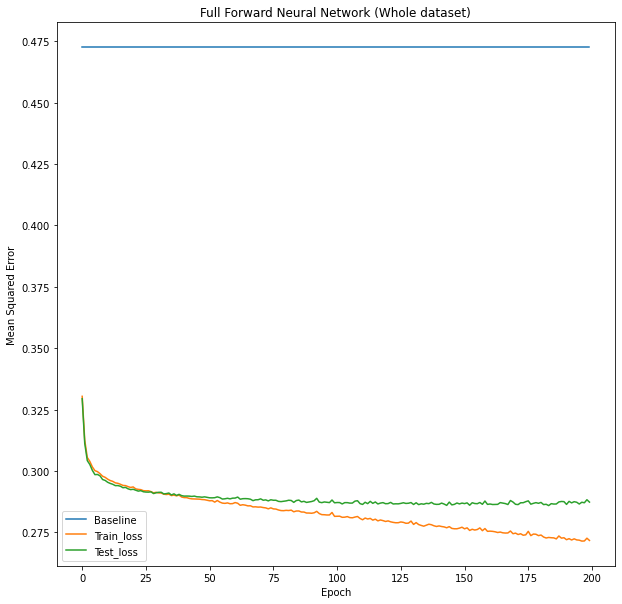

In [42]:
if train_FFN is True:

  # Show results of the loss function whole

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses_FFN))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_FFN], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_FFN], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Whole dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

#min values in numpy array
minval = np.amin([np.mean(i) for i in test_losses_FFN])
print('min value in array:',minval)
indice = np.where([np.mean(i) for i in test_losses_FFN] == np.amin([np.mean(i) for i in test_losses_FFN]))
print('min value index:',indice[0])

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [26]:
class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, dim_feedforward: int=2048, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)

    def positional_encoding(self, seq_len: int, dim_model: int, device):

        position_encoding = torch.zeros(seq_len, dim_model)

        for pos in range(seq_len):
          for i in range(0, int(dim_model / 2)):
            position_encoding[pos, 2 * i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
            position_encoding[pos, (2 * i) + 1] = math.cos(pos / (10000 ** ((2 * i)/dim_model)))

        position_encoding = position_encoding.to(device)

        return position_encoding
        
    def forward (self, enc_input, dec_input):
        
        memory_mask = self.generate_square_mask(len(enc_input))

        src_pos_enc = enc_input + self.positional_encoding(seq_len= enc_input.shape[1], dim_model= enc_input.shape[2], device= self.device)
        src_pos_dec = dec_input + self.positional_encoding(seq_len= dec_input.shape[1], dim_model= dec_input.shape[2], device= self.device)

        output = self.encoder (src= src_pos_enc, mask=None)
        output = self.decoder (tgt= src_pos_dec, memory= output, tgt_mask=None, memory_mask=None)
        
        return output

In [27]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs, device):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [33]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = False

if train_transformer is True:
  trained_model_transformer_1, train_losses_1, test_losses_1 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if False:
  np.save('Transformer_Vanilla_train.npy', train_losses_1)
  np.save('Transformer_Vanilla_test.npy', test_losses_1)

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.07it/s]



Current Mean loss Train Set:  0.4135045367171515

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.92it/s]



Current Mean loss Test Set:  0.42151523885702846


Epoch: 2 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 40.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.56it/s]



Current Mean loss Train Set:  0.3808497270689966

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.86it/s]



Current Mean loss Test Set:  0.39023017322625775


Epoch: 3 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.95it/s]



Current Mean loss Train Set:  0.3673461053500576

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.09it/s]



Current Mean loss Test Set:  0.37713876953630737


Epoch: 4 of 200
Training...


100%|██████████| 3563/3563 [01:27<00:00, 40.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.54it/s]



Current Mean loss Train Set:  0.35879987129042934

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.24it/s]



Current Mean loss Test Set:  0.3685171137554477


Epoch: 5 of 200
Training...


100%|██████████| 3563/3563 [01:27<00:00, 40.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.40it/s]



Current Mean loss Train Set:  0.3543248327091909

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.36it/s]



Current Mean loss Test Set:  0.36382451604562577


Epoch: 6 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.21it/s]



Current Mean loss Train Set:  0.350501330735106

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.94it/s]



Current Mean loss Test Set:  0.3604470922639876


Epoch: 7 of 200
Training...


100%|██████████| 3563/3563 [01:27<00:00, 40.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.90it/s]



Current Mean loss Train Set:  0.34747359995138705

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.75it/s]



Current Mean loss Test Set:  0.3574712906747755


Epoch: 8 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.26it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 117.94it/s]



Current Mean loss Train Set:  0.34458785866071695

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.63it/s]



Current Mean loss Test Set:  0.3550751761655615


Epoch: 9 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.13it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.40it/s]



Current Mean loss Train Set:  0.3421485983033947

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.18it/s]



Current Mean loss Test Set:  0.35264251053784834


Epoch: 10 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.99it/s]



Current Mean loss Train Set:  0.3401230276760144

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.50it/s]



Current Mean loss Test Set:  0.35088572451713107


Epoch: 11 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 40.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.97it/s]



Current Mean loss Train Set:  0.33887620127012047

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.57it/s]



Current Mean loss Test Set:  0.3493728572973097


Epoch: 12 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.35it/s]



Current Mean loss Train Set:  0.3359978093739276

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.98it/s]



Current Mean loss Test Set:  0.346342350836053


Epoch: 13 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.90it/s]



Current Mean loss Train Set:  0.3347277693197428

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.27it/s]



Current Mean loss Test Set:  0.34525328129529953


Epoch: 14 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 40.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.46it/s]



Current Mean loss Train Set:  0.33293661512403117

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.39it/s]



Current Mean loss Test Set:  0.3439543866599449


Epoch: 15 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.56it/s]



Current Mean loss Train Set:  0.33217615290635627

Test with test set


100%|██████████| 396/396 [00:03<00:00, 116.85it/s]



Current Mean loss Test Set:  0.3426683436364237


Epoch: 16 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.69it/s]



Current Mean loss Train Set:  0.3305742694836067

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.04it/s]



Current Mean loss Test Set:  0.3414163544322505


Epoch: 17 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.48it/s]



Current Mean loss Train Set:  0.3295154189155104

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.27it/s]



Current Mean loss Test Set:  0.34047022177790753


Epoch: 18 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.77it/s]



Current Mean loss Train Set:  0.32882416355803945

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.07it/s]



Current Mean loss Test Set:  0.33963047600153723


Epoch: 19 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.16it/s]



Current Mean loss Train Set:  0.3281493896690105

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.84it/s]



Current Mean loss Test Set:  0.3394182032406932


Epoch: 20 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.16it/s]



Current Mean loss Train Set:  0.3272710063970728

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.87it/s]



Current Mean loss Test Set:  0.3381667367812961


Epoch: 21 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.49it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.10it/s]



Current Mean loss Train Set:  0.32695082699084865

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.02it/s]



Current Mean loss Test Set:  0.337661720097366


Epoch: 22 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.52it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.22it/s]



Current Mean loss Train Set:  0.32512637452566656

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.63it/s]



Current Mean loss Test Set:  0.3358229631275842


Epoch: 23 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.52it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.48it/s]



Current Mean loss Train Set:  0.3243398158412417

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.39it/s]



Current Mean loss Test Set:  0.33530405826038784


Epoch: 24 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.50it/s]



Current Mean loss Train Set:  0.32559392676112897

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.98it/s]



Current Mean loss Test Set:  0.3371933388213317


Epoch: 25 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.57it/s]



Current Mean loss Train Set:  0.3238260398670893

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.35it/s]



Current Mean loss Test Set:  0.3344397367627332


Epoch: 26 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.64it/s]



Current Mean loss Train Set:  0.32206677392003846

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.68it/s]



Current Mean loss Test Set:  0.3324573022322823


Epoch: 27 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.33it/s]



Current Mean loss Train Set:  0.3213012139808252

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.44it/s]



Current Mean loss Test Set:  0.3329321075644758


Epoch: 28 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.68it/s]



Current Mean loss Train Set:  0.3206449969661995

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.11it/s]



Current Mean loss Test Set:  0.33216649907255413


Epoch: 29 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.40it/s]



Current Mean loss Train Set:  0.3188186242628593

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.19it/s]



Current Mean loss Test Set:  0.33016933192207354


Epoch: 30 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.58it/s]



Current Mean loss Train Set:  0.3171916060523976

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.45it/s]



Current Mean loss Test Set:  0.32848920812359966


Epoch: 31 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.52it/s]



Current Mean loss Train Set:  0.3137182810882521

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.60it/s]



Current Mean loss Test Set:  0.3251909768641597


Epoch: 32 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.26it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.46it/s]



Current Mean loss Train Set:  0.31114609383931163

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.00it/s]



Current Mean loss Test Set:  0.3225552642887289


Epoch: 33 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.04it/s]



Current Mean loss Train Set:  0.3078997301049123

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.21it/s]



Current Mean loss Test Set:  0.3198791489080347


Epoch: 34 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.26it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.97it/s]



Current Mean loss Train Set:  0.30974093788867246

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.29it/s]



Current Mean loss Test Set:  0.32216603060563404


Epoch: 35 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.66it/s]



Current Mean loss Train Set:  0.3096595040673859

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.67it/s]



Current Mean loss Test Set:  0.32237388092008507


Epoch: 36 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.71it/s]



Current Mean loss Train Set:  0.30482470955142404

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.55it/s]



Current Mean loss Test Set:  0.31685719097202475


Epoch: 37 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.38it/s]



Current Mean loss Train Set:  0.30177431935854854

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.05it/s]



Current Mean loss Test Set:  0.3143869817181669


Epoch: 38 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.32it/s]



Current Mean loss Train Set:  0.29968467037554974

Test with test set


100%|██████████| 396/396 [00:03<00:00, 114.30it/s]



Current Mean loss Test Set:  0.31269478814845736


Epoch: 39 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.23it/s]



Current Mean loss Train Set:  0.30212136741948203

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.03it/s]



Current Mean loss Test Set:  0.31493387269702827


Epoch: 40 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.28it/s]



Current Mean loss Train Set:  0.29691854708572135

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.79it/s]



Current Mean loss Test Set:  0.30895007571036165


Epoch: 41 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.96it/s]



Current Mean loss Train Set:  0.2970894801731261

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.74it/s]



Current Mean loss Test Set:  0.31045090444762297


Epoch: 42 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:31<00:00, 114.55it/s]



Current Mean loss Train Set:  0.2965296532581303

Test with test set


100%|██████████| 396/396 [00:03<00:00, 109.84it/s]



Current Mean loss Test Set:  0.3104917999507502


Epoch: 43 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.02it/s]



Current Mean loss Train Set:  0.29728075659930825

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.21it/s]



Current Mean loss Test Set:  0.3111042357379138


Epoch: 44 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.78it/s]



Current Mean loss Train Set:  0.29124792075971856

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.60it/s]



Current Mean loss Test Set:  0.3043981547834295


Epoch: 45 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.16it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.54it/s]



Current Mean loss Train Set:  0.2950821592985597

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.63it/s]



Current Mean loss Test Set:  0.30804164098067716


Epoch: 46 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.97it/s]



Current Mean loss Train Set:  0.28746103854609983

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.59it/s]



Current Mean loss Test Set:  0.301551715329741


Epoch: 47 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.45it/s]



Current Mean loss Train Set:  0.2923443013848698

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.44it/s]



Current Mean loss Test Set:  0.30603214921523825


Epoch: 48 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.95it/s]



Current Mean loss Train Set:  0.2904315825667804

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.43it/s]



Current Mean loss Test Set:  0.30417520003487364


Epoch: 49 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.13it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.26it/s]



Current Mean loss Train Set:  0.28499314771746104

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.09it/s]



Current Mean loss Test Set:  0.2983841144978398


Epoch: 50 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.05it/s]



Current Mean loss Train Set:  0.2898553725715738

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.43it/s]



Current Mean loss Test Set:  0.3029438264743246


Epoch: 51 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.83it/s]



Current Mean loss Train Set:  0.2827355464125262

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.07it/s]



Current Mean loss Test Set:  0.296370873810968


Epoch: 52 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.71it/s]



Current Mean loss Train Set:  0.28072553709329195

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.21it/s]



Current Mean loss Test Set:  0.29355163552393815


Epoch: 53 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.16it/s]



Current Mean loss Train Set:  0.27967583354632575

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.18it/s]



Current Mean loss Test Set:  0.29323011971633844


Epoch: 54 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.61it/s]



Current Mean loss Train Set:  0.28288561163442444

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.82it/s]



Current Mean loss Test Set:  0.2963817360425236


Epoch: 55 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.24it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.69it/s]



Current Mean loss Train Set:  0.2791684376383778

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.20it/s]



Current Mean loss Test Set:  0.2922353084302611


Epoch: 56 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.71it/s]



Current Mean loss Train Set:  0.27795861874726124

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.37it/s]



Current Mean loss Test Set:  0.2912338564191202


Epoch: 57 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.43it/s]



Current Mean loss Train Set:  0.2790475889262509

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.15it/s]



Current Mean loss Test Set:  0.2924129074683996


Epoch: 58 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.13it/s]



Current Mean loss Train Set:  0.27814372419608363

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.05it/s]



Current Mean loss Test Set:  0.29120992673466906


Epoch: 59 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.62it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.13it/s]



Current Mean loss Train Set:  0.2747666080856872

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.53it/s]



Current Mean loss Test Set:  0.2875154498738773


Epoch: 60 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.55it/s]



Current Mean loss Train Set:  0.2750099479395153

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.37it/s]



Current Mean loss Test Set:  0.28791277061658677


Epoch: 61 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.43it/s]



Current Mean loss Train Set:  0.2728299361361134

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.51it/s]



Current Mean loss Test Set:  0.28585374763592925


Epoch: 62 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.38it/s]



Current Mean loss Train Set:  0.2763424420809264

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.38it/s]



Current Mean loss Test Set:  0.28942281854423607


Epoch: 63 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.13it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.88it/s]



Current Mean loss Train Set:  0.2748490355798043

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.45it/s]



Current Mean loss Test Set:  0.28834484254169945


Epoch: 64 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.61it/s]



Current Mean loss Train Set:  0.27474422833155354

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.53it/s]



Current Mean loss Test Set:  0.28797479910832463


Epoch: 65 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.04it/s]



Current Mean loss Train Set:  0.27169112057965894

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.63it/s]



Current Mean loss Test Set:  0.2847948614131622


Epoch: 66 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.22it/s]



Current Mean loss Train Set:  0.2717207382184014

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.39it/s]



Current Mean loss Test Set:  0.28495142546792823


Epoch: 67 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.01it/s]



Current Mean loss Train Set:  0.2769677449010444

Test with test set


100%|██████████| 396/396 [00:03<00:00, 115.58it/s]



Current Mean loss Test Set:  0.2904689587615054


Epoch: 68 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.56it/s]



Current Mean loss Train Set:  0.26995247040375747

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.69it/s]



Current Mean loss Test Set:  0.2835348974348921


Epoch: 69 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.56it/s]



Current Mean loss Train Set:  0.2722899416148445

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.10it/s]



Current Mean loss Test Set:  0.28590198350374146


Epoch: 70 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.93it/s]



Current Mean loss Train Set:  0.26868895082461375

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.77it/s]



Current Mean loss Test Set:  0.28133601505271716


Epoch: 71 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.40it/s]



Current Mean loss Train Set:  0.26837775778885875

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.05it/s]



Current Mean loss Test Set:  0.2812836608200362


Epoch: 72 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.69it/s]



Current Mean loss Train Set:  0.27288234914926673

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.40it/s]



Current Mean loss Test Set:  0.28579823006734706


Epoch: 73 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.94it/s]



Current Mean loss Train Set:  0.2668055874697285

Test with test set


100%|██████████| 396/396 [00:03<00:00, 113.55it/s]



Current Mean loss Test Set:  0.27996773541801506


Epoch: 74 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.35it/s]



Current Mean loss Train Set:  0.26630010302360224

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.87it/s]



Current Mean loss Test Set:  0.27949552401674516


Epoch: 75 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.11it/s]



Current Mean loss Train Set:  0.26561066694191726

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.75it/s]



Current Mean loss Test Set:  0.2789687310543024


Epoch: 76 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.43it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.81it/s]



Current Mean loss Train Set:  0.2676346847934399

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.89it/s]



Current Mean loss Test Set:  0.2805156634386742


Epoch: 77 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.58it/s]



Current Mean loss Train Set:  0.27257514258398624

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.84it/s]



Current Mean loss Test Set:  0.28604395501315594


Epoch: 78 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.87it/s]



Current Mean loss Train Set:  0.2658014148201897

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.16it/s]



Current Mean loss Test Set:  0.27874289200914026


Epoch: 79 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.08it/s]



Current Mean loss Train Set:  0.2711681788962375

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.72it/s]



Current Mean loss Test Set:  0.28450140065391255


Epoch: 80 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.73it/s]



Current Mean loss Train Set:  0.26503547408374684

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.91it/s]



Current Mean loss Test Set:  0.2779223949582589


Epoch: 81 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.33it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.22it/s]



Current Mean loss Train Set:  0.2648051123404282

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.89it/s]



Current Mean loss Test Set:  0.2776507004493415


Epoch: 82 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.41it/s]



Current Mean loss Train Set:  0.264306615319792

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.60it/s]



Current Mean loss Test Set:  0.27683388264943853


Epoch: 83 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.45it/s]



Current Mean loss Train Set:  0.2630853618450992

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.52it/s]



Current Mean loss Test Set:  0.2764193270204946


Epoch: 84 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.20it/s]



Current Mean loss Train Set:  0.2627449905729314

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.58it/s]



Current Mean loss Test Set:  0.27583383546784673


Epoch: 85 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.91it/s]



Current Mean loss Train Set:  0.26300423446788634

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.18it/s]



Current Mean loss Test Set:  0.27547769188278853


Epoch: 86 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.86it/s]



Current Mean loss Train Set:  0.2629977763932875

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.74it/s]



Current Mean loss Test Set:  0.27639537169174716


Epoch: 87 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.75it/s]



Current Mean loss Train Set:  0.26198371651590524

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.13it/s]



Current Mean loss Test Set:  0.2745500733379764


Epoch: 88 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.31it/s]



Current Mean loss Train Set:  0.263627951295062

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.97it/s]



Current Mean loss Test Set:  0.27705243843221905


Epoch: 89 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.09it/s]



Current Mean loss Train Set:  0.2616341453659344

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.10it/s]



Current Mean loss Test Set:  0.27462917882384674


Epoch: 90 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.29it/s]



Current Mean loss Train Set:  0.2618821164027981

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.49it/s]



Current Mean loss Test Set:  0.27524464837077894


Epoch: 91 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.02it/s]



Current Mean loss Train Set:  0.2631509454438367

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.74it/s]



Current Mean loss Test Set:  0.2763580298145311


Epoch: 92 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.79it/s]



Current Mean loss Train Set:  0.26041300822527197

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.71it/s]



Current Mean loss Test Set:  0.27405499098728403


Epoch: 93 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.72it/s]



Current Mean loss Train Set:  0.2618913315874353

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.36it/s]



Current Mean loss Test Set:  0.2740922722626816


Epoch: 94 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.35it/s]



Current Mean loss Train Set:  0.2596034446510076

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.49it/s]



Current Mean loss Test Set:  0.2719123890491748


Epoch: 95 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.66it/s]



Current Mean loss Train Set:  0.26092747543054184

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.12it/s]



Current Mean loss Test Set:  0.2739977209330207


Epoch: 96 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.94it/s]



Current Mean loss Train Set:  0.2601424607372739

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.94it/s]



Current Mean loss Test Set:  0.2735825946197064


Epoch: 97 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.83it/s]



Current Mean loss Train Set:  0.26320639378337624

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.67it/s]



Current Mean loss Test Set:  0.27584403200131474


Epoch: 98 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.30it/s]



Current Mean loss Train Set:  0.26343562712653984

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.53it/s]



Current Mean loss Test Set:  0.27685214966686084


Epoch: 99 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.41it/s]



Current Mean loss Train Set:  0.2614975975904276

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.91it/s]



Current Mean loss Test Set:  0.27515763687816536


Epoch: 100 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.68it/s]



Current Mean loss Train Set:  0.25992609551707047

Test with test set


100%|██████████| 396/396 [00:03<00:00, 116.49it/s]



Current Mean loss Test Set:  0.27286462267540923


Epoch: 101 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.54it/s]



Current Mean loss Train Set:  0.2589161664920846

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.20it/s]



Current Mean loss Test Set:  0.2720706903121688


Epoch: 102 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.00it/s]



Current Mean loss Train Set:  0.2576902844377726

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.56it/s]



Current Mean loss Test Set:  0.27084816489933117


Epoch: 103 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.59it/s]



Current Mean loss Train Set:  0.25853659802906104

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.58it/s]



Current Mean loss Test Set:  0.27135318813074116


Epoch: 104 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.66it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.84it/s]



Current Mean loss Train Set:  0.25728255816675993

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.69it/s]



Current Mean loss Test Set:  0.2698016037995165


Epoch: 105 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.69it/s]



Current Mean loss Train Set:  0.2587766424009648

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.12it/s]



Current Mean loss Test Set:  0.2725966705028156


Epoch: 106 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.63it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.67it/s]



Current Mean loss Train Set:  0.25697054523883694

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.78it/s]



Current Mean loss Test Set:  0.27121769969887805


Epoch: 107 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.18it/s]



Current Mean loss Train Set:  0.2589570620493744

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.00it/s]



Current Mean loss Test Set:  0.2728403669716132


Epoch: 108 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.84it/s]



Current Mean loss Train Set:  0.2577847589498452

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.13it/s]



Current Mean loss Test Set:  0.2718613724403008


Epoch: 109 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.53it/s]



Current Mean loss Train Set:  0.2562226163405834

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.71it/s]



Current Mean loss Test Set:  0.268745409193063


Epoch: 110 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.64it/s]



Current Mean loss Train Set:  0.2578970940635675

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.77it/s]



Current Mean loss Test Set:  0.27180189552782763


Epoch: 111 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.74it/s]



Current Mean loss Train Set:  0.25605343025435967

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.98it/s]



Current Mean loss Test Set:  0.26996703758233725


Epoch: 112 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 42.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.68it/s]



Current Mean loss Train Set:  0.2566382613554785

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.49it/s]



Current Mean loss Test Set:  0.2703384600128188


Epoch: 113 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.40it/s]



Current Mean loss Train Set:  0.2571472230061801

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.36it/s]



Current Mean loss Test Set:  0.2708700063139802


Epoch: 114 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.57it/s]



Current Mean loss Train Set:  0.25702903586811743

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.12it/s]



Current Mean loss Test Set:  0.27016993401327516


Epoch: 115 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.30it/s]



Current Mean loss Train Set:  0.25653191038164036

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.89it/s]



Current Mean loss Test Set:  0.26960486450204346


Epoch: 116 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.55it/s]



Current Mean loss Train Set:  0.2559991370329287

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.02it/s]



Current Mean loss Test Set:  0.2687147380125643


Epoch: 117 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.75it/s]



Current Mean loss Train Set:  0.25529791814137337

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.46it/s]



Current Mean loss Test Set:  0.2683609550950503


Epoch: 118 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.13it/s]



Current Mean loss Train Set:  0.25442300337295404

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.12it/s]



Current Mean loss Test Set:  0.2679722991141707


Epoch: 119 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.36it/s]



Current Mean loss Train Set:  0.2547866189426296

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.11it/s]



Current Mean loss Test Set:  0.26813326247337493


Epoch: 120 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.84it/s]



Current Mean loss Train Set:  0.25339622412074525

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.51it/s]



Current Mean loss Test Set:  0.2670817492021756


Epoch: 121 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 42.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.58it/s]



Current Mean loss Train Set:  0.25792028214609963

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.53it/s]



Current Mean loss Test Set:  0.2711986560148723


Epoch: 122 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.03it/s]



Current Mean loss Train Set:  0.2541201479843818

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.05it/s]



Current Mean loss Test Set:  0.2675685922831598


Epoch: 123 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.96it/s]



Current Mean loss Train Set:  0.25488495139586537

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.65it/s]



Current Mean loss Test Set:  0.26903889283086313


Epoch: 124 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.17it/s]



Current Mean loss Train Set:  0.2532728391895795

Test with test set


100%|██████████| 396/396 [00:03<00:00, 128.06it/s]



Current Mean loss Test Set:  0.2668482839609637


Epoch: 125 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.19it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.87it/s]



Current Mean loss Train Set:  0.2532948920591608

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.00it/s]



Current Mean loss Test Set:  0.2662054353741684


Epoch: 126 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.78it/s]



Current Mean loss Train Set:  0.2545252570544205

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.23it/s]



Current Mean loss Test Set:  0.2678712713108821


Epoch: 127 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.98it/s]



Current Mean loss Train Set:  0.25401529729567046

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.77it/s]



Current Mean loss Test Set:  0.26780352109309397


Epoch: 128 of 200
Training...


100%|██████████| 3563/3563 [01:21<00:00, 43.52it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.61it/s]



Current Mean loss Train Set:  0.2538532985187701

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.03it/s]



Current Mean loss Test Set:  0.2679389153767114


Epoch: 129 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.29it/s]



Current Mean loss Train Set:  0.25382223345157373

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.98it/s]



Current Mean loss Test Set:  0.26786748534350685


Epoch: 130 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.01it/s]



Current Mean loss Train Set:  0.2519236748581718

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.36it/s]



Current Mean loss Test Set:  0.2663375604521446


Epoch: 131 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.00it/s]



Current Mean loss Train Set:  0.2530326823187182

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.54it/s]



Current Mean loss Test Set:  0.2666909717061002


Epoch: 132 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.41it/s]



Current Mean loss Train Set:  0.25193932279630754

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.96it/s]



Current Mean loss Test Set:  0.26603429967706854


Epoch: 133 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.87it/s]



Current Mean loss Train Set:  0.2538237565401194

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.02it/s]



Current Mean loss Test Set:  0.26791633902625606


Epoch: 134 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.94it/s]



Current Mean loss Train Set:  0.25098863188015286

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.27it/s]



Current Mean loss Test Set:  0.2654553214370301


Epoch: 135 of 200
Training...


100%|██████████| 3563/3563 [01:21<00:00, 43.46it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.87it/s]



Current Mean loss Train Set:  0.25289186483357284

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.21it/s]



Current Mean loss Test Set:  0.26726740768009966


Epoch: 136 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.43it/s]



Current Mean loss Train Set:  0.25308718043216116

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.85it/s]



Current Mean loss Test Set:  0.2674040562200426


Epoch: 137 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.19it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.26it/s]



Current Mean loss Train Set:  0.25133947770882614

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.56it/s]



Current Mean loss Test Set:  0.26531938425820284


Epoch: 138 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.88it/s]



Current Mean loss Train Set:  0.251814990999439

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.33it/s]



Current Mean loss Test Set:  0.26600436815484


Epoch: 139 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.32it/s]



Current Mean loss Train Set:  0.2555045085176805

Test with test set


100%|██████████| 396/396 [00:03<00:00, 127.47it/s]



Current Mean loss Test Set:  0.27082499556920747


Epoch: 140 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.35it/s]



Current Mean loss Train Set:  0.25185576285994393

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.20it/s]



Current Mean loss Test Set:  0.26624418971966013


Epoch: 141 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.30it/s]



Current Mean loss Train Set:  0.2503443638528293

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.84it/s]



Current Mean loss Test Set:  0.26511080233812934


Epoch: 142 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.23it/s]



Current Mean loss Train Set:  0.249969016199128

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.65it/s]



Current Mean loss Test Set:  0.2640503592826802


Epoch: 143 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.27it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.74it/s]



Current Mean loss Train Set:  0.2521366412251343

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.52it/s]



Current Mean loss Test Set:  0.2674922379994332


Epoch: 144 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.00it/s]



Current Mean loss Train Set:  0.2520525867881114

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.41it/s]



Current Mean loss Test Set:  0.26688787499160477


Epoch: 145 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.68it/s]



Current Mean loss Train Set:  0.24944226272088438

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.62it/s]



Current Mean loss Test Set:  0.2633487228492294


Epoch: 146 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.74it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.16it/s]



Current Mean loss Train Set:  0.2517772318731022

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.71it/s]



Current Mean loss Test Set:  0.2670339564933921


Epoch: 147 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.58it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.78it/s]



Current Mean loss Train Set:  0.24991541559939434

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.04it/s]



Current Mean loss Test Set:  0.2640178985141142


Epoch: 148 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.22it/s]



Current Mean loss Train Set:  0.24771430686956838

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.94it/s]



Current Mean loss Test Set:  0.2622422528914129


Epoch: 149 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.15it/s]



Current Mean loss Train Set:  0.24928976960925617

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.21it/s]



Current Mean loss Test Set:  0.26312991318227064


Epoch: 150 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.32it/s]



Current Mean loss Train Set:  0.2500796766887379

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.14it/s]



Current Mean loss Test Set:  0.26433994359515534


Epoch: 151 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.66it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.34it/s]



Current Mean loss Train Set:  0.24964381668454236

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.51it/s]



Current Mean loss Test Set:  0.2633585627331878


Epoch: 152 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.77it/s]



Current Mean loss Train Set:  0.2483735933163813

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.20it/s]



Current Mean loss Test Set:  0.2629025299854652


Epoch: 153 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.70it/s]



Current Mean loss Train Set:  0.2492268281959263

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.40it/s]



Current Mean loss Test Set:  0.26319749706020257


Epoch: 154 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.61it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.22it/s]



Current Mean loss Train Set:  0.2472549736407778

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.94it/s]



Current Mean loss Test Set:  0.2613702785562385


Epoch: 155 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.58it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.55it/s]



Current Mean loss Train Set:  0.24768601035071397

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.78it/s]



Current Mean loss Test Set:  0.26142039413403984


Epoch: 156 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.60it/s]



Current Mean loss Train Set:  0.2482886672931677

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.22it/s]



Current Mean loss Test Set:  0.2621448693251369


Epoch: 157 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.61it/s]



Current Mean loss Train Set:  0.2487880901409741

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.14it/s]



Current Mean loss Test Set:  0.2633232589848716


Epoch: 158 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.75it/s]



Current Mean loss Train Set:  0.24697497704333213

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.56it/s]



Current Mean loss Test Set:  0.2613927029600047


Epoch: 159 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.58it/s]



Current Mean loss Train Set:  0.24771725857505428

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.07it/s]



Current Mean loss Test Set:  0.2635823823887892


Epoch: 160 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.73it/s]



Current Mean loss Train Set:  0.24787449772743372

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.58it/s]



Current Mean loss Test Set:  0.2636261582562719


Epoch: 161 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 41.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.03it/s]



Current Mean loss Train Set:  0.250667942766808

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.76it/s]



Current Mean loss Test Set:  0.2660430633660519


Epoch: 162 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.63it/s]



Current Mean loss Train Set:  0.2502143376418255

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.94it/s]



Current Mean loss Test Set:  0.2650086756870903


Epoch: 163 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.96it/s]



Current Mean loss Train Set:  0.24984965449784066

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.23it/s]



Current Mean loss Test Set:  0.26588772517638376


Epoch: 164 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.66it/s]



Current Mean loss Train Set:  0.248422237843434

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.77it/s]



Current Mean loss Test Set:  0.26338456271950045


Epoch: 165 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.39it/s]



Current Mean loss Train Set:  0.24579774374427202

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.63it/s]



Current Mean loss Test Set:  0.2604331401449562


Epoch: 166 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.77it/s]



Current Mean loss Train Set:  0.24690733979023008

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.84it/s]



Current Mean loss Test Set:  0.26142070436793746


Epoch: 167 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.51it/s]



Current Mean loss Train Set:  0.24886084733770833

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.38it/s]



Current Mean loss Test Set:  0.2647507992206198


Epoch: 168 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.57it/s]



Current Mean loss Train Set:  0.24603563789701716

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.39it/s]



Current Mean loss Test Set:  0.26015597045647376


Epoch: 169 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.64it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.61it/s]



Current Mean loss Train Set:  0.2461649442581424

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.93it/s]



Current Mean loss Test Set:  0.26118847136997214


Epoch: 170 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.23it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.06it/s]



Current Mean loss Train Set:  0.24750732513598903

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.05it/s]



Current Mean loss Test Set:  0.2628712361358633


Epoch: 171 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.82it/s]



Current Mean loss Train Set:  0.24624318612983578

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.87it/s]



Current Mean loss Test Set:  0.26054447417081605


Epoch: 172 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.17it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.49it/s]



Current Mean loss Train Set:  0.24819404648790994

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.60it/s]



Current Mean loss Test Set:  0.26141012971750416


Epoch: 173 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.17it/s]



Current Mean loss Train Set:  0.24617655759082896

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.98it/s]



Current Mean loss Test Set:  0.2607578212263608


Epoch: 174 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.20it/s]



Current Mean loss Train Set:  0.24569809194858108

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.88it/s]



Current Mean loss Test Set:  0.2610153048252217


Epoch: 175 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.81it/s]



Current Mean loss Train Set:  0.24573407586483081

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.21it/s]



Current Mean loss Test Set:  0.2611786441106086


Epoch: 176 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.23it/s]



Current Mean loss Train Set:  0.24462449883531392

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.55it/s]



Current Mean loss Test Set:  0.2604424842078276


Epoch: 177 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 42.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.48it/s]



Current Mean loss Train Set:  0.24746168033647764

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.85it/s]



Current Mean loss Test Set:  0.2611488539048217


Epoch: 178 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.07it/s]



Current Mean loss Train Set:  0.24660873354744314

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.18it/s]



Current Mean loss Test Set:  0.2617174767785602


Epoch: 179 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.50it/s]



Current Mean loss Train Set:  0.24289432826911736

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.36it/s]



Current Mean loss Test Set:  0.25912505032663996


Epoch: 180 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.35it/s]



Current Mean loss Train Set:  0.2480049730162757

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.19it/s]



Current Mean loss Test Set:  0.26337728242982517


Epoch: 181 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.07it/s]



Current Mean loss Train Set:  0.24352692018482347

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.79it/s]



Current Mean loss Test Set:  0.2584348795653293


Epoch: 182 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.74it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.47it/s]



Current Mean loss Train Set:  0.2469234613159584

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.61it/s]



Current Mean loss Test Set:  0.26299615759364886


Epoch: 183 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.13it/s]



Current Mean loss Train Set:  0.24499679782351783

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.00it/s]



Current Mean loss Test Set:  0.26144032434306363


Epoch: 184 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.38it/s]



Current Mean loss Train Set:  0.24413921213738876

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.99it/s]



Current Mean loss Test Set:  0.25922713477653686


Epoch: 185 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.25it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.52it/s]



Current Mean loss Train Set:  0.24384829689077606

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.07it/s]



Current Mean loss Test Set:  0.26004004689178084


Epoch: 186 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.39it/s]



Current Mean loss Train Set:  0.24248534581725129

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.89it/s]



Current Mean loss Test Set:  0.257940258680269


Epoch: 187 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.66it/s]



Current Mean loss Train Set:  0.24327793213848048

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.33it/s]



Current Mean loss Test Set:  0.2591504402684443


Epoch: 188 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.15it/s]



Current Mean loss Train Set:  0.24332738034542176

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.45it/s]



Current Mean loss Test Set:  0.2592690721003696


Epoch: 189 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.60it/s]



Current Mean loss Train Set:  0.24327597602754372

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.90it/s]



Current Mean loss Test Set:  0.2585702831998016


Epoch: 190 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.32it/s]



Current Mean loss Train Set:  0.24423643800479924

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.80it/s]



Current Mean loss Test Set:  0.2601011675227471


Epoch: 191 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.83it/s]



Current Mean loss Train Set:  0.24547538961540807

Test with test set


100%|██████████| 396/396 [00:03<00:00, 127.11it/s]



Current Mean loss Test Set:  0.26082807419953324


Epoch: 192 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.67it/s]



Current Mean loss Train Set:  0.24349753570764077

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.59it/s]



Current Mean loss Test Set:  0.2594126300566425


Epoch: 193 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.00it/s]



Current Mean loss Train Set:  0.24156476923615083

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.08it/s]



Current Mean loss Test Set:  0.2570822525092147


Epoch: 194 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.09it/s]



Current Mean loss Train Set:  0.2413489043047647

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.01it/s]



Current Mean loss Test Set:  0.25731283932397464


Epoch: 195 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.38it/s]



Current Mean loss Train Set:  0.24116420949104292

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.22it/s]



Current Mean loss Test Set:  0.2569964646803911


Epoch: 196 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.53it/s]



Current Mean loss Train Set:  0.24016339872832249

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.56it/s]



Current Mean loss Test Set:  0.2559901615886977


Epoch: 197 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 125.09it/s]



Current Mean loss Train Set:  0.24155903540900875

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.28it/s]



Current Mean loss Test Set:  0.25749059362017146


Epoch: 198 of 200
Training...


100%|██████████| 3563/3563 [01:26<00:00, 41.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.77it/s]



Current Mean loss Train Set:  0.24171197800833022

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.49it/s]



Current Mean loss Test Set:  0.2572496123423781


Epoch: 199 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.30it/s]



Current Mean loss Train Set:  0.2417284402198548

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.06it/s]



Current Mean loss Test Set:  0.256983005056026


Epoch: 200 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.67it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.94it/s]



Current Mean loss Train Set:  0.24218612189561237

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.10it/s]


Current Mean loss Test Set:  0.25846077855488264


Training time: 23354.230764 seconds


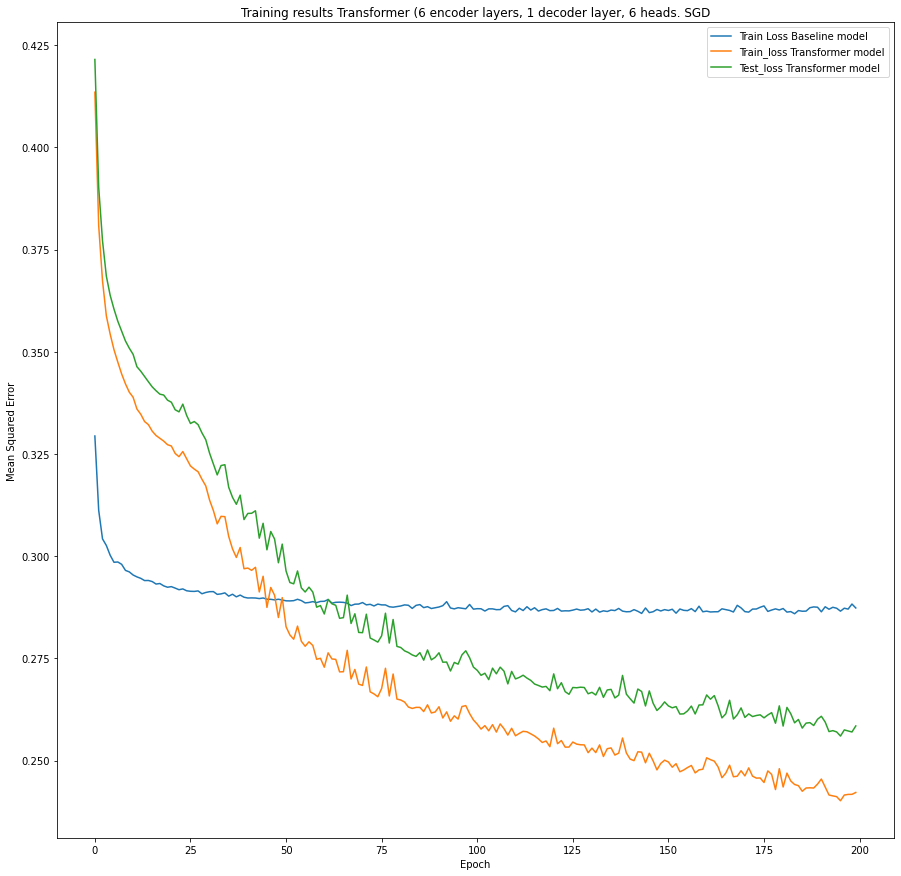

In [43]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_FFN], label= 'Train Loss Baseline model')

  ax.plot([np.mean(i) for i in train_losses_1], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [44]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.001)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_2, train_losses_2, test_losses_2 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

# save to npy file
if train_transformer is True:
  np.save('Transformer_ADAM_train.npy', train_losses_2)
  np.save('Transformer_ADAM_test.npy', test_losses_2)

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.32it/s]



Current Mean loss Train Set:  0.343332271336037

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.00it/s]



Current Mean loss Test Set:  0.35316876826262233


Epoch: 2 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.64it/s]



Current Mean loss Train Set:  0.33278762570700215

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.26it/s]



Current Mean loss Test Set:  0.34172109540815304


Epoch: 3 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.60it/s]



Current Mean loss Train Set:  0.3407313210841079

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.83it/s]



Current Mean loss Test Set:  0.3513083467354076


Epoch: 4 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.73it/s]



Current Mean loss Train Set:  0.3254669357594097

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.49it/s]



Current Mean loss Test Set:  0.3354614887273673


Epoch: 5 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.44it/s]



Current Mean loss Train Set:  0.31997127458766844

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.62it/s]



Current Mean loss Test Set:  0.3308199236940856


Epoch: 6 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.46it/s]



Current Mean loss Train Set:  0.31888518949597866

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.10it/s]



Current Mean loss Test Set:  0.3302124244621908


Epoch: 7 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.55it/s]



Current Mean loss Train Set:  0.3238143402808107

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.61it/s]



Current Mean loss Test Set:  0.33420385619757154


Epoch: 8 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.73it/s]



Current Mean loss Train Set:  0.32300676727249755

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.41it/s]



Current Mean loss Test Set:  0.3341891837466245


Epoch: 9 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.93it/s]



Current Mean loss Train Set:  0.318523274540667

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.08it/s]



Current Mean loss Test Set:  0.32865313749120695


Epoch: 10 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.46it/s]



Current Mean loss Train Set:  0.3169663311673656

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.37it/s]



Current Mean loss Test Set:  0.3276424956592647


Epoch: 11 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.38it/s]



Current Mean loss Train Set:  0.31710132917401296

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.74it/s]



Current Mean loss Test Set:  0.32742879765503335


Epoch: 12 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.93it/s]



Current Mean loss Train Set:  0.32006085023948927

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.61it/s]



Current Mean loss Test Set:  0.33115795288573613


Epoch: 13 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.16it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.91it/s]



Current Mean loss Train Set:  0.31587105868590737

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.38it/s]



Current Mean loss Test Set:  0.326168610968373


Epoch: 14 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.76it/s]



Current Mean loss Train Set:  0.31712680163843193

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.53it/s]



Current Mean loss Test Set:  0.32814623411707206


Epoch: 15 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.13it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.72it/s]



Current Mean loss Train Set:  0.3149726485356233

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.72it/s]



Current Mean loss Test Set:  0.3253659799205835


Epoch: 16 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.16it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.61it/s]



Current Mean loss Train Set:  0.31455217664650975

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.01it/s]



Current Mean loss Test Set:  0.3244328885292164


Epoch: 17 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.71it/s]



Current Mean loss Train Set:  0.31229536604411207

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.87it/s]



Current Mean loss Test Set:  0.3220124240362584


Epoch: 18 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.56it/s]



Current Mean loss Train Set:  0.31589881056167424

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.52it/s]



Current Mean loss Test Set:  0.32545812586040207


Epoch: 19 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.45it/s]



Current Mean loss Train Set:  0.3116207127403149

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.06it/s]



Current Mean loss Test Set:  0.32196356107791263


Epoch: 20 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.56it/s]



Current Mean loss Train Set:  0.3125416757374241

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.80it/s]



Current Mean loss Test Set:  0.32267269405602206


Epoch: 21 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.02it/s]



Current Mean loss Train Set:  0.3129099209950006

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.22it/s]



Current Mean loss Test Set:  0.32292706380137287


Epoch: 22 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.58it/s]



Current Mean loss Train Set:  0.31353787369158304

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.08it/s]



Current Mean loss Test Set:  0.32426241879360845


Epoch: 23 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.63it/s]



Current Mean loss Train Set:  0.3148621747914807

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.44it/s]



Current Mean loss Test Set:  0.3252480100802701


Epoch: 24 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.75it/s]



Current Mean loss Train Set:  0.3127441458882926

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.11it/s]



Current Mean loss Test Set:  0.3228972533510791


Epoch: 25 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.08it/s]



Current Mean loss Train Set:  0.3154770619968601

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.51it/s]



Current Mean loss Test Set:  0.32631884293273244


Epoch: 26 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.66it/s]



Current Mean loss Train Set:  0.3144227001934181

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.13it/s]



Current Mean loss Test Set:  0.32445480373471675


Epoch: 27 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.14it/s]



Current Mean loss Train Set:  0.3137110849837724

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.07it/s]



Current Mean loss Test Set:  0.32333571493926677


Epoch: 28 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.66it/s]



Current Mean loss Train Set:  0.3114800138914983

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.33it/s]



Current Mean loss Test Set:  0.3216697286174755


Epoch: 29 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.37it/s]



Current Mean loss Train Set:  0.31160782549008537

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.03it/s]



Current Mean loss Test Set:  0.3222882695910003


Epoch: 30 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.67it/s]



Current Mean loss Train Set:  0.31708116406784476

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.41it/s]



Current Mean loss Test Set:  0.32761181394259137


Epoch: 31 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.26it/s]



Current Mean loss Train Set:  0.3113830541748028

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.49it/s]



Current Mean loss Test Set:  0.32193089528667806


Epoch: 32 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.95it/s]



Current Mean loss Train Set:  0.31140180606705536

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.38it/s]



Current Mean loss Test Set:  0.32160377201407847


Epoch: 33 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.91it/s]



Current Mean loss Train Set:  0.31013544411127936

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.63it/s]



Current Mean loss Test Set:  0.32066143744371156


Epoch: 34 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.54it/s]



Current Mean loss Train Set:  0.3101622323570143

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.74it/s]



Current Mean loss Test Set:  0.32043696734866106


Epoch: 35 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.94it/s]



Current Mean loss Train Set:  0.3105396485996989

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.56it/s]



Current Mean loss Test Set:  0.3201812467340267


Epoch: 36 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.60it/s]



Current Mean loss Train Set:  0.311297954956434

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.06it/s]



Current Mean loss Test Set:  0.3214085193896534


Epoch: 37 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.74it/s]



Current Mean loss Train Set:  0.31301269235694273

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.45it/s]



Current Mean loss Test Set:  0.32345049790661745


Epoch: 38 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.27it/s]



Current Mean loss Train Set:  0.3126849160832098

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.34it/s]



Current Mean loss Test Set:  0.3225358673042119


Epoch: 39 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.67it/s]



Current Mean loss Train Set:  0.31380694610054427

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.43it/s]



Current Mean loss Test Set:  0.32512452867296004


Epoch: 40 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.70it/s]



Current Mean loss Train Set:  0.3077362768232839

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.42it/s]



Current Mean loss Test Set:  0.3180246554465607


Epoch: 41 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.93it/s]



Current Mean loss Train Set:  0.31178284071776896

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.51it/s]



Current Mean loss Test Set:  0.32205886858506033


Epoch: 42 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.11it/s]



Current Mean loss Train Set:  0.3129271581756443

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.00it/s]



Current Mean loss Test Set:  0.3231283419323389


Epoch: 43 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.15it/s]



Current Mean loss Train Set:  0.3110722479711849

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.01it/s]



Current Mean loss Test Set:  0.321499690977913


Epoch: 44 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.96it/s]



Current Mean loss Train Set:  0.30942170478355474

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.12it/s]



Current Mean loss Test Set:  0.3193258692632721


Epoch: 45 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.52it/s]



Current Mean loss Train Set:  0.3102597847137597

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.69it/s]



Current Mean loss Test Set:  0.3204522473417749


Epoch: 46 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.65it/s]



Current Mean loss Train Set:  0.30995186708748357

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.91it/s]



Current Mean loss Test Set:  0.32038779530410816


Epoch: 47 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.90it/s]



Current Mean loss Train Set:  0.30883662240778903

Test with test set


100%|██████████| 396/396 [00:03<00:00, 116.17it/s]



Current Mean loss Test Set:  0.31869226332866785


Epoch: 48 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.41it/s]



Current Mean loss Train Set:  0.3131074937305657

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.20it/s]



Current Mean loss Test Set:  0.32323838486289136


Epoch: 49 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.05it/s]



Current Mean loss Train Set:  0.3086100014895326

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.85it/s]



Current Mean loss Test Set:  0.3188903159414879


Epoch: 50 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.71it/s]



Current Mean loss Train Set:  0.3118686099384328

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.19it/s]



Current Mean loss Test Set:  0.3222780359739607


Epoch: 51 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.26it/s]



Current Mean loss Train Set:  0.3079077758181473

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.61it/s]



Current Mean loss Test Set:  0.31879771711549376


Epoch: 52 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.41it/s]



Current Mean loss Train Set:  0.3130102086620922

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.65it/s]



Current Mean loss Test Set:  0.3229511249622311


Epoch: 53 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.08it/s]



Current Mean loss Train Set:  0.30963290746446875

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.42it/s]



Current Mean loss Test Set:  0.31968282102936446


Epoch: 54 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.46it/s]



Current Mean loss Train Set:  0.31069923170306124

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.34it/s]



Current Mean loss Test Set:  0.32082978543834856


Epoch: 55 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.06it/s]



Current Mean loss Train Set:  0.31036423767571564

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.66it/s]



Current Mean loss Test Set:  0.32061227234174505


Epoch: 56 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.00it/s]



Current Mean loss Train Set:  0.307492954913164

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.30it/s]



Current Mean loss Test Set:  0.31800631663263446


Epoch: 57 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.59it/s]



Current Mean loss Train Set:  0.3094398255825645

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.17it/s]



Current Mean loss Test Set:  0.31917472887370324


Epoch: 58 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.76it/s]



Current Mean loss Train Set:  0.3116609002310608

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.24it/s]



Current Mean loss Test Set:  0.32193998992443085


Epoch: 59 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.36it/s]



Current Mean loss Train Set:  0.3104845860279279

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.49it/s]



Current Mean loss Test Set:  0.32135460145696243


Epoch: 60 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.28it/s]



Current Mean loss Train Set:  0.3095125950331304

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.41it/s]



Current Mean loss Test Set:  0.31906330226120927


Epoch: 61 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.02it/s]



Current Mean loss Train Set:  0.3130526327949677

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.28it/s]



Current Mean loss Test Set:  0.324416638229682


Epoch: 62 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.24it/s]



Current Mean loss Train Set:  0.3098816022803835

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.26it/s]



Current Mean loss Test Set:  0.3199196756074224


Epoch: 63 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.36it/s]



Current Mean loss Train Set:  0.30734982487695656

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.69it/s]



Current Mean loss Test Set:  0.31835273062490455


Epoch: 64 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.65it/s]



Current Mean loss Train Set:  0.31306208008516045

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.85it/s]



Current Mean loss Test Set:  0.3243953061826301


Epoch: 65 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.16it/s]



Current Mean loss Train Set:  0.3093421722069872

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.75it/s]



Current Mean loss Test Set:  0.32014999877322803


Epoch: 66 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.17it/s]



Current Mean loss Train Set:  0.3098706059239401

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.07it/s]



Current Mean loss Test Set:  0.32108422195670583


Epoch: 67 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.68it/s]



Current Mean loss Train Set:  0.3081578738818067

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.91it/s]



Current Mean loss Test Set:  0.31848450814082163


Epoch: 68 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.42it/s]



Current Mean loss Train Set:  0.3094854420393396

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.82it/s]



Current Mean loss Test Set:  0.31997348326775765


Epoch: 69 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.97it/s]



Current Mean loss Train Set:  0.31399456640784407

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.22it/s]



Current Mean loss Test Set:  0.32488214457877956


Epoch: 70 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.53it/s]



Current Mean loss Train Set:  0.3090180446559246

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.74it/s]



Current Mean loss Test Set:  0.319733469718785


Epoch: 71 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.50it/s]



Current Mean loss Train Set:  0.30993251665201277

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.17it/s]



Current Mean loss Test Set:  0.32009205276692154


Epoch: 72 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.16it/s]



Current Mean loss Train Set:  0.30667825131445764

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.55it/s]



Current Mean loss Test Set:  0.3163149016297827


Epoch: 73 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.70it/s]



Current Mean loss Train Set:  0.3073985877559488

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.92it/s]



Current Mean loss Test Set:  0.31837911478648284


Epoch: 74 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.74it/s]



Current Mean loss Train Set:  0.31093560805355536

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.89it/s]



Current Mean loss Test Set:  0.32135715333726067


Epoch: 75 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.91it/s]



Current Mean loss Train Set:  0.3091190281169086

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.07it/s]



Current Mean loss Test Set:  0.3198858711003053


Epoch: 76 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.67it/s]



Current Mean loss Train Set:  0.3080524738073985

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.49it/s]



Current Mean loss Test Set:  0.3200844289979549


Epoch: 77 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.10it/s]



Current Mean loss Train Set:  0.31434266373552766

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.78it/s]



Current Mean loss Test Set:  0.32543007160226506


Epoch: 78 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.41it/s]



Current Mean loss Train Set:  0.30819973413349705

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.47it/s]



Current Mean loss Test Set:  0.31924782253124495


Epoch: 79 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.23it/s]



Current Mean loss Train Set:  0.3087925315070547

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.42it/s]



Current Mean loss Test Set:  0.31936737736969284


Epoch: 80 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.55it/s]



Current Mean loss Train Set:  0.3087454229831662

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.65it/s]



Current Mean loss Test Set:  0.31956218672220155


Epoch: 81 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.79it/s]



Current Mean loss Train Set:  0.30800718270658345

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.77it/s]



Current Mean loss Test Set:  0.31842352995517276


Epoch: 82 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.10it/s]



Current Mean loss Train Set:  0.3099802702920443

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.44it/s]



Current Mean loss Test Set:  0.32049151336905934


Epoch: 83 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.70it/s]



Current Mean loss Train Set:  0.3102884487848318

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.50it/s]



Current Mean loss Test Set:  0.3203900008641108


Epoch: 84 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.86it/s]



Current Mean loss Train Set:  0.309295963940328

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.76it/s]



Current Mean loss Test Set:  0.31958474512353086


Epoch: 85 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.72it/s]



Current Mean loss Train Set:  0.308166836227656

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.69it/s]



Current Mean loss Test Set:  0.31970158283307093


Epoch: 86 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.27it/s]



Current Mean loss Train Set:  0.31134013614350414

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.46it/s]



Current Mean loss Test Set:  0.3217942546112369


Epoch: 87 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.87it/s]



Current Mean loss Train Set:  0.30848061735630705

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.82it/s]



Current Mean loss Test Set:  0.31868592510470234


Epoch: 88 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.87it/s]



Current Mean loss Train Set:  0.31187982300786266

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.26it/s]



Current Mean loss Test Set:  0.3223462350139714


Epoch: 89 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.93it/s]



Current Mean loss Train Set:  0.31118749950939506

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.71it/s]



Current Mean loss Test Set:  0.32218922386792576


Epoch: 90 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.74it/s]



Current Mean loss Train Set:  0.31103425439099

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.90it/s]



Current Mean loss Test Set:  0.32207531781133375


Epoch: 91 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.16it/s]



Current Mean loss Train Set:  0.3081671134528236

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.39it/s]



Current Mean loss Test Set:  0.3187977098342445


Epoch: 92 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.68it/s]



Current Mean loss Train Set:  0.3086395646196351

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.52it/s]



Current Mean loss Test Set:  0.3193924373034576


Epoch: 93 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.36it/s]



Current Mean loss Train Set:  0.3078029568074728

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.71it/s]



Current Mean loss Test Set:  0.31875145307393987


Epoch: 94 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.09it/s]



Current Mean loss Train Set:  0.3070871094986692

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.12it/s]



Current Mean loss Test Set:  0.31889040820827386


Epoch: 95 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.92it/s]



Current Mean loss Train Set:  0.30940525326590307

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.62it/s]



Current Mean loss Test Set:  0.3188233830109991


Epoch: 96 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.41it/s]



Current Mean loss Train Set:  0.309443062745869

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.05it/s]



Current Mean loss Test Set:  0.320125713342368


Epoch: 97 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.44it/s]



Current Mean loss Train Set:  0.3103767316427721

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.75it/s]



Current Mean loss Test Set:  0.320593878927857


Epoch: 98 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.84it/s]



Current Mean loss Train Set:  0.3075179670559132

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.04it/s]



Current Mean loss Test Set:  0.3183668093624139


Epoch: 99 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.44it/s]



Current Mean loss Train Set:  0.30808114822731236

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.59it/s]



Current Mean loss Test Set:  0.31877210977101567


Epoch: 100 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.86it/s]



Current Mean loss Train Set:  0.30541635445629384

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.26it/s]



Current Mean loss Test Set:  0.3163244209130003


Epoch: 101 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.17it/s]



Current Mean loss Train Set:  0.308413180194057

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.83it/s]



Current Mean loss Test Set:  0.3192445719708698


Epoch: 102 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.81it/s]



Current Mean loss Train Set:  0.30457878029567287

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.87it/s]



Current Mean loss Test Set:  0.3142799005815477


Epoch: 103 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.97it/s]



Current Mean loss Train Set:  0.3095480769584094

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.63it/s]



Current Mean loss Test Set:  0.3205003251293392


Epoch: 104 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.20it/s]



Current Mean loss Train Set:  0.30977007088837183

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.47it/s]



Current Mean loss Test Set:  0.3204616367666408


Epoch: 105 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.01it/s]



Current Mean loss Train Set:  0.30678059174510625

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.15it/s]



Current Mean loss Test Set:  0.3178891291597275


Epoch: 106 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.23it/s]



Current Mean loss Train Set:  0.3084771113970492

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.63it/s]



Current Mean loss Test Set:  0.3194240896840288


Epoch: 107 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.99it/s]



Current Mean loss Train Set:  0.30797961319752565

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.46it/s]



Current Mean loss Test Set:  0.317476324737072


Epoch: 108 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.78it/s]



Current Mean loss Train Set:  0.31068928423278824

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.04it/s]



Current Mean loss Test Set:  0.3222486637344565


Epoch: 109 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.68it/s]



Current Mean loss Train Set:  0.30998331602373186

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.52it/s]



Current Mean loss Test Set:  0.32056944807897314


Epoch: 110 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.42it/s]



Current Mean loss Train Set:  0.3101030629762866

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.21it/s]



Current Mean loss Test Set:  0.3206740896208118


Epoch: 111 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.53it/s]



Current Mean loss Train Set:  0.309746929347398

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.01it/s]



Current Mean loss Test Set:  0.3209691770525292


Epoch: 112 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.43it/s]



Current Mean loss Train Set:  0.30746760568339737

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.88it/s]



Current Mean loss Test Set:  0.3181701978348722


Epoch: 113 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.75it/s]



Current Mean loss Train Set:  0.30765214401610674

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.72it/s]



Current Mean loss Test Set:  0.31868083188028046


Epoch: 114 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.03it/s]



Current Mean loss Train Set:  0.30929640691425236

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.19it/s]



Current Mean loss Test Set:  0.3201463741786552


Epoch: 115 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.97it/s]



Current Mean loss Train Set:  0.3068556033332061

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.32it/s]



Current Mean loss Test Set:  0.3169552730490463


Epoch: 116 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.49it/s]



Current Mean loss Train Set:  0.30592340220277175

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.25it/s]



Current Mean loss Test Set:  0.31704974065374847


Epoch: 117 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.31it/s]



Current Mean loss Train Set:  0.30854866111877427

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.31it/s]



Current Mean loss Test Set:  0.3185872780253189


Epoch: 118 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.90it/s]



Current Mean loss Train Set:  0.30774857163839114

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.77it/s]



Current Mean loss Test Set:  0.31720018744318174


Epoch: 119 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.29it/s]



Current Mean loss Train Set:  0.30841384204943595

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.38it/s]



Current Mean loss Test Set:  0.31934640349613297


Epoch: 120 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.84it/s]



Current Mean loss Train Set:  0.3087591726626702

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.36it/s]



Current Mean loss Test Set:  0.3194575166198039


Epoch: 121 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.26it/s]



Current Mean loss Train Set:  0.30525414845789883

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.52it/s]



Current Mean loss Test Set:  0.3159546541294666


Epoch: 122 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.52it/s]



Current Mean loss Train Set:  0.3097841122257987

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.76it/s]



Current Mean loss Test Set:  0.32117943488287204


Epoch: 123 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.35it/s]



Current Mean loss Train Set:  0.31174637305537467

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.63it/s]



Current Mean loss Test Set:  0.323074828720454


Epoch: 124 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.19it/s]



Current Mean loss Train Set:  0.3056970415676105

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.80it/s]



Current Mean loss Test Set:  0.31610447042292417


Epoch: 125 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.14it/s]



Current Mean loss Train Set:  0.3093205313087179

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.85it/s]



Current Mean loss Test Set:  0.31962251448721596


Epoch: 126 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.14it/s]



Current Mean loss Train Set:  0.3064678884162315

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.07it/s]



Current Mean loss Test Set:  0.3176280942867802


Epoch: 127 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.55it/s]



Current Mean loss Train Set:  0.308403543824732

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.15it/s]



Current Mean loss Test Set:  0.31881621583468384


Epoch: 128 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.44it/s]



Current Mean loss Train Set:  0.30527456463796854

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.34it/s]



Current Mean loss Test Set:  0.31619023162909227


Epoch: 129 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.29it/s]



Current Mean loss Train Set:  0.3044701257499456

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.07it/s]



Current Mean loss Test Set:  0.31481649824465163


Epoch: 130 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.24it/s]



Current Mean loss Train Set:  0.3097011885769642

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.53it/s]



Current Mean loss Test Set:  0.3200173864536213


Epoch: 131 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.48it/s]



Current Mean loss Train Set:  0.30587307877113

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.86it/s]



Current Mean loss Test Set:  0.3163185419909882


Epoch: 132 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.48it/s]



Current Mean loss Train Set:  0.30605262077962153

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.24it/s]



Current Mean loss Test Set:  0.31627550525496706


Epoch: 133 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.67it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.24it/s]



Current Mean loss Train Set:  0.30768752503338204

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.30it/s]



Current Mean loss Test Set:  0.3178499847876303


Epoch: 134 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.60it/s]



Current Mean loss Train Set:  0.3067768241079912

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.44it/s]



Current Mean loss Test Set:  0.3177285801355887


Epoch: 135 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.48it/s]



Current Mean loss Train Set:  0.30591830688808663

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.08it/s]



Current Mean loss Test Set:  0.3167640682723787


Epoch: 136 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.07it/s]



Current Mean loss Train Set:  0.30639765172602923

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.72it/s]



Current Mean loss Test Set:  0.3168323576412719


Epoch: 137 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.30it/s]



Current Mean loss Train Set:  0.30706086099658025

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.55it/s]



Current Mean loss Test Set:  0.3173651075498624


Epoch: 138 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.06it/s]



Current Mean loss Train Set:  0.3093712633387312

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.50it/s]



Current Mean loss Test Set:  0.31992723802198664


Epoch: 139 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.15it/s]



Current Mean loss Train Set:  0.3067575636168996

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.59it/s]



Current Mean loss Test Set:  0.31734116119567796


Epoch: 140 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.39it/s]



Current Mean loss Train Set:  0.31049017539159524

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.29it/s]



Current Mean loss Test Set:  0.3209244024309546


Epoch: 141 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.93it/s]



Current Mean loss Train Set:  0.30897626288103447

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.71it/s]



Current Mean loss Test Set:  0.31989670401871806


Epoch: 142 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.70it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.91it/s]



Current Mean loss Train Set:  0.3067809118670491

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.77it/s]



Current Mean loss Test Set:  0.31801862457785945


Epoch: 143 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.02it/s]



Current Mean loss Train Set:  0.306958708984277

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.88it/s]



Current Mean loss Test Set:  0.3170823171132743


Epoch: 144 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.46it/s]



Current Mean loss Train Set:  0.308081456662111

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.42it/s]



Current Mean loss Test Set:  0.3186568175677699


Epoch: 145 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.51it/s]



Current Mean loss Train Set:  0.3085616363310225

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.63it/s]



Current Mean loss Test Set:  0.31846201395371343


Epoch: 146 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.39it/s]



Current Mean loss Train Set:  0.3071598601021728

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.66it/s]



Current Mean loss Test Set:  0.3179976599987107


Epoch: 147 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.59it/s]



Current Mean loss Train Set:  0.30749788992849253

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.75it/s]



Current Mean loss Test Set:  0.31861468573862856


Epoch: 148 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.91it/s]



Current Mean loss Train Set:  0.3059978928587392

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.77it/s]



Current Mean loss Test Set:  0.3158948914044433


Epoch: 149 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.23it/s]



Current Mean loss Train Set:  0.3103756958468724

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.21it/s]



Current Mean loss Test Set:  0.3213540157397287


Epoch: 150 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.79it/s]



Current Mean loss Train Set:  0.30973988934962426

Test with test set


100%|██████████| 396/396 [00:03<00:00, 115.83it/s]



Current Mean loss Test Set:  0.3210854351972089


Epoch: 151 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 117.94it/s]



Current Mean loss Train Set:  0.3052237824822556

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.31it/s]



Current Mean loss Test Set:  0.31650786120632685


Epoch: 152 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 117.62it/s]



Current Mean loss Train Set:  0.30566717844028807

Test with test set


100%|██████████| 396/396 [00:03<00:00, 116.93it/s]



Current Mean loss Test Set:  0.3158872125651499


Epoch: 153 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.31it/s]



Current Mean loss Train Set:  0.30910018794269933

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.06it/s]



Current Mean loss Test Set:  0.31859178457296256


Epoch: 154 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.18it/s]



Current Mean loss Train Set:  0.30447894222710264

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.28it/s]



Current Mean loss Test Set:  0.3151298735403653


Epoch: 155 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.08it/s]



Current Mean loss Train Set:  0.30963649298371543

Test with test set


100%|██████████| 396/396 [00:03<00:00, 115.67it/s]



Current Mean loss Test Set:  0.3206858799764604


Epoch: 156 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.02it/s]



Current Mean loss Train Set:  0.3081669900927054

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.14it/s]



Current Mean loss Test Set:  0.3188507067547603


Epoch: 157 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.76it/s]



Current Mean loss Train Set:  0.3082117947164025

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.89it/s]



Current Mean loss Test Set:  0.31844685271833884


Epoch: 158 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.22it/s]



Current Mean loss Train Set:  0.3060300762114517

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.74it/s]



Current Mean loss Test Set:  0.31600611779199106


Epoch: 159 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.36it/s]



Current Mean loss Train Set:  0.3053894799590579

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.35it/s]



Current Mean loss Test Set:  0.31632602512083874


Epoch: 160 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.15it/s]



Current Mean loss Train Set:  0.30890159296363784

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.82it/s]



Current Mean loss Test Set:  0.320123764074812


Epoch: 161 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.84it/s]



Current Mean loss Train Set:  0.3108280745849595

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.87it/s]



Current Mean loss Test Set:  0.3203912852990507


Epoch: 162 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.55it/s]



Current Mean loss Train Set:  0.3087331774635928

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.46it/s]



Current Mean loss Test Set:  0.3188391361536101


Epoch: 163 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.69it/s]



Current Mean loss Train Set:  0.3084924520964941

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.69it/s]



Current Mean loss Test Set:  0.3188739875425594


Epoch: 164 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.14it/s]



Current Mean loss Train Set:  0.3078518438913867

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.18it/s]



Current Mean loss Test Set:  0.31785814155532854


Epoch: 165 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.40it/s]



Current Mean loss Train Set:  0.30480856445066185

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.77it/s]



Current Mean loss Test Set:  0.31541788743601906


Epoch: 166 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 115.45it/s]



Current Mean loss Train Set:  0.3103594307108371

Test with test set


100%|██████████| 396/396 [00:03<00:00, 116.49it/s]



Current Mean loss Test Set:  0.32068049452371067


Epoch: 167 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.54it/s]



Current Mean loss Train Set:  0.3050126635247056

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.90it/s]



Current Mean loss Test Set:  0.31516196352965903


Epoch: 168 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.95it/s]



Current Mean loss Train Set:  0.309756679899014

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.32it/s]



Current Mean loss Test Set:  0.32044432244517584


Epoch: 169 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.92it/s]



Current Mean loss Train Set:  0.3059753356352469

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.02it/s]



Current Mean loss Test Set:  0.3159455724737861


Epoch: 170 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.77it/s]



Current Mean loss Train Set:  0.3069419187485519

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.25it/s]



Current Mean loss Test Set:  0.3176898377938102


Epoch: 171 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.89it/s]



Current Mean loss Train Set:  0.3098661794760841

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.71it/s]



Current Mean loss Test Set:  0.32024030786271046


Epoch: 172 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.13it/s]



Current Mean loss Train Set:  0.307688818414861

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.84it/s]



Current Mean loss Test Set:  0.31886608040694037


Epoch: 173 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.85it/s]



Current Mean loss Train Set:  0.3094512438012113

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.62it/s]



Current Mean loss Test Set:  0.31945964221776735


Epoch: 174 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.45it/s]



Current Mean loss Train Set:  0.30857632967685

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.35it/s]



Current Mean loss Test Set:  0.31899200742970213


Epoch: 175 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.37it/s]



Current Mean loss Train Set:  0.30978804692069767

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.53it/s]



Current Mean loss Test Set:  0.3206014107498858


Epoch: 176 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.28it/s]



Current Mean loss Train Set:  0.3057391452586052

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.88it/s]



Current Mean loss Test Set:  0.31607386620357786


Epoch: 177 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.95it/s]



Current Mean loss Train Set:  0.30893688166732036

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.63it/s]



Current Mean loss Test Set:  0.3189124495468356


Epoch: 178 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.47it/s]



Current Mean loss Train Set:  0.3055100565942994

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.43it/s]



Current Mean loss Test Set:  0.3163676686359174


Epoch: 179 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.29it/s]



Current Mean loss Train Set:  0.31027014169203176

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.96it/s]



Current Mean loss Test Set:  0.32067101110111584


Epoch: 180 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.20it/s]



Current Mean loss Train Set:  0.3062938218881433

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.94it/s]



Current Mean loss Test Set:  0.31564231183041225


Epoch: 181 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.22it/s]



Current Mean loss Train Set:  0.3078383205564645

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.99it/s]



Current Mean loss Test Set:  0.3182552269462383


Epoch: 182 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.79it/s]



Current Mean loss Train Set:  0.30759394429404513

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.27it/s]



Current Mean loss Test Set:  0.3191458299153983


Epoch: 183 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.86it/s]



Current Mean loss Train Set:  0.30886790017306454

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.79it/s]



Current Mean loss Test Set:  0.31968775169566427


Epoch: 184 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.92it/s]



Current Mean loss Train Set:  0.3098068502309481

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.96it/s]



Current Mean loss Test Set:  0.32016119364686685


Epoch: 185 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.68it/s]



Current Mean loss Train Set:  0.3061944953982261

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.09it/s]



Current Mean loss Test Set:  0.3173843412989318


Epoch: 186 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.61it/s]



Current Mean loss Train Set:  0.3038483166247983

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.36it/s]



Current Mean loss Test Set:  0.31417127277212914


Epoch: 187 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.00it/s]



Current Mean loss Train Set:  0.3076948953179238

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.33it/s]



Current Mean loss Test Set:  0.31851732362099366


Epoch: 188 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.63it/s]



Current Mean loss Train Set:  0.30698959771339857

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.29it/s]



Current Mean loss Test Set:  0.31650236783304597


Epoch: 189 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.67it/s]



Current Mean loss Train Set:  0.3061814882402804

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.53it/s]



Current Mean loss Test Set:  0.31694590149804797


Epoch: 190 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.35it/s]



Current Mean loss Train Set:  0.30834423985469217

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.01it/s]



Current Mean loss Test Set:  0.31893351367401956


Epoch: 191 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.29it/s]



Current Mean loss Train Set:  0.30643869207927826

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.87it/s]



Current Mean loss Test Set:  0.3157369941473007


Epoch: 192 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.30it/s]



Current Mean loss Train Set:  0.3061964066697579

Test with test set


100%|██████████| 396/396 [00:03<00:00, 115.70it/s]



Current Mean loss Test Set:  0.3165147081017494


Epoch: 193 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.06it/s]



Current Mean loss Train Set:  0.3071734548919896

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.90it/s]



Current Mean loss Test Set:  0.3173417660473573


Epoch: 194 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.04it/s]



Current Mean loss Train Set:  0.30886492493645784

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.70it/s]



Current Mean loss Test Set:  0.3195153548560961


Epoch: 195 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.76it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.27it/s]



Current Mean loss Train Set:  0.30685147624687636

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.82it/s]



Current Mean loss Test Set:  0.31746664598132623


Epoch: 196 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.60it/s]



Current Mean loss Train Set:  0.30538459784013317

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.52it/s]



Current Mean loss Test Set:  0.3159039535493863


Epoch: 197 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.76it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.12it/s]



Current Mean loss Train Set:  0.30525001462987056

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.27it/s]



Current Mean loss Test Set:  0.3150745375138341


Epoch: 198 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.52it/s]



Current Mean loss Train Set:  0.3053284491899306

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.83it/s]



Current Mean loss Test Set:  0.31548056807933433


Epoch: 199 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.20it/s]



Current Mean loss Train Set:  0.3093125601932971

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.94it/s]



Current Mean loss Test Set:  0.31975689481454667


Epoch: 200 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.00it/s]



Current Mean loss Train Set:  0.3043548794687547

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.28it/s]



Current Mean loss Test Set:  0.31532575641617633


26918527.287 miliseconds


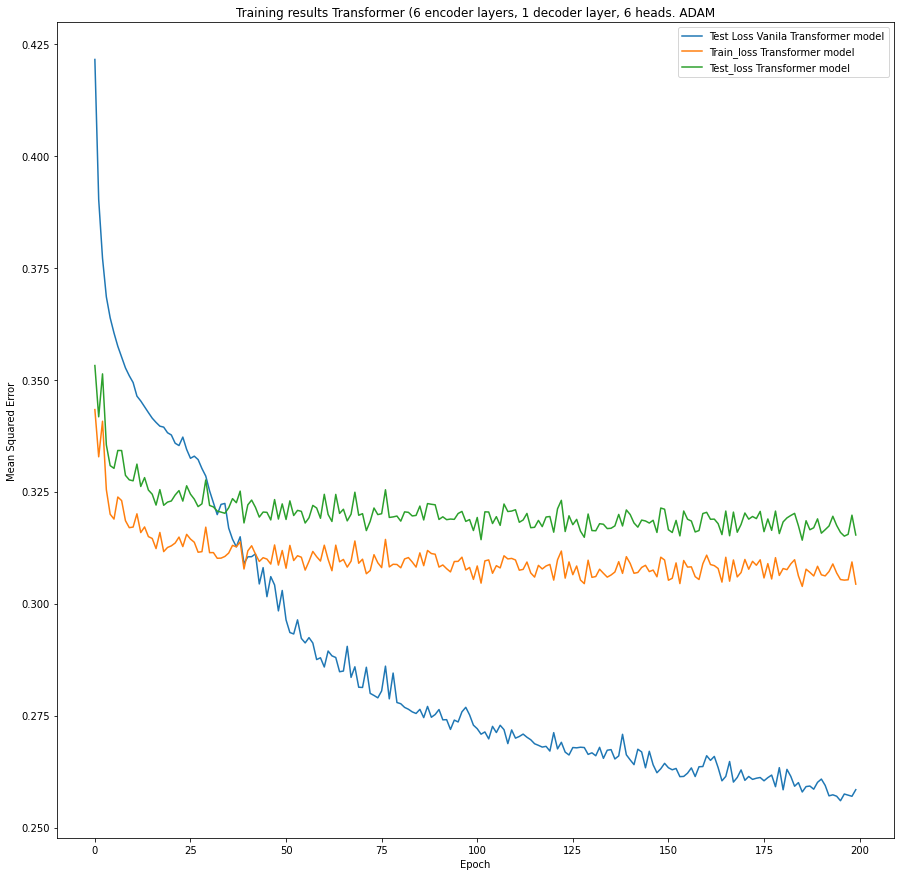

In [45]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_2], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_2], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. ADAM")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_3, train_losses_3, test_losses_3 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

# save to npy file
if True:
  np.save('Transformer_SGDmom_train.npy', train_losses_3)
  np.save('Transformer_SGDmon_test.npy', test_losses_3)

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3563/3563 [01:30<00:00, 39.23it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 127.07it/s]



Current Mean loss Train Set:  0.3653828233078963

Test with test set


100%|██████████| 396/396 [00:03<00:00, 127.30it/s]



Current Mean loss Test Set:  0.37099685493593265


Epoch: 2 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 128.46it/s]



Current Mean loss Train Set:  0.341979426557918

Test with test set


100%|██████████| 396/396 [00:03<00:00, 128.84it/s]



Current Mean loss Test Set:  0.3488621291789142


Epoch: 3 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 130.59it/s]



Current Mean loss Train Set:  0.34233935356742373

Test with test set


100%|██████████| 396/396 [00:02<00:00, 133.01it/s]



Current Mean loss Test Set:  0.3482131818779791


Epoch: 4 of 200
Training...


100%|██████████| 3563/3563 [01:24<00:00, 42.16it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 130.43it/s]



Current Mean loss Train Set:  0.3427351545265408

Test with test set


100%|██████████| 396/396 [00:02<00:00, 133.09it/s]



Current Mean loss Test Set:  0.3512115066852232


Epoch: 5 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 131.81it/s]



Current Mean loss Train Set:  0.331454219525027

Test with test set


100%|██████████| 396/396 [00:03<00:00, 129.26it/s]



Current Mean loss Test Set:  0.3388667876145454


Epoch: 6 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 131.49it/s]



Current Mean loss Train Set:  0.3305319648025881

Test with test set


100%|██████████| 396/396 [00:02<00:00, 132.26it/s]



Current Mean loss Test Set:  0.33635406730451967


Epoch: 7 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.66it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 131.96it/s]



Current Mean loss Train Set:  0.3266781868536988

Test with test set


100%|██████████| 396/396 [00:03<00:00, 130.38it/s]



Current Mean loss Test Set:  0.33480803502930534


Epoch: 8 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 42.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:26<00:00, 132.41it/s]



Current Mean loss Train Set:  0.3317425576758258

Test with test set


100%|██████████| 396/396 [00:03<00:00, 131.18it/s]



Current Mean loss Test Set:  0.3397973588093965


Epoch: 9 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 130.37it/s]



Current Mean loss Train Set:  0.33446122208464324

Test with test set


100%|██████████| 396/396 [00:02<00:00, 133.11it/s]



Current Mean loss Test Set:  0.34308254421509876


Epoch: 10 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 42.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:26<00:00, 132.04it/s]



Current Mean loss Train Set:  0.31868765776056335

Test with test set


100%|██████████| 396/396 [00:03<00:00, 131.27it/s]



Current Mean loss Test Set:  0.3269236609339714


Epoch: 11 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:26<00:00, 132.82it/s]



Current Mean loss Train Set:  0.3083478637288502

Test with test set


100%|██████████| 396/396 [00:02<00:00, 132.37it/s]



Current Mean loss Test Set:  0.31701783135984885


Epoch: 12 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 131.01it/s]



Current Mean loss Train Set:  0.2922975711258917

Test with test set


100%|██████████| 396/396 [00:03<00:00, 130.20it/s]



Current Mean loss Test Set:  0.3021396156212296


Epoch: 13 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 131.80it/s]



Current Mean loss Train Set:  0.28921457462445627

Test with test set


100%|██████████| 396/396 [00:02<00:00, 132.48it/s]



Current Mean loss Test Set:  0.3001195274556827


Epoch: 14 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 131.67it/s]



Current Mean loss Train Set:  0.28519694238416005

Test with test set


100%|██████████| 396/396 [00:02<00:00, 132.11it/s]



Current Mean loss Test Set:  0.29571473278632066


Epoch: 15 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.68it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 131.68it/s]



Current Mean loss Train Set:  0.2863963161823357

Test with test set


100%|██████████| 396/396 [00:02<00:00, 132.04it/s]



Current Mean loss Test Set:  0.2986270333781387


Epoch: 16 of 200
Training...


100%|██████████| 3563/3563 [01:23<00:00, 42.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 131.96it/s]



Current Mean loss Train Set:  0.2769147027811909

Test with test set


100%|██████████| 396/396 [00:02<00:00, 134.99it/s]



Current Mean loss Test Set:  0.2915268089960922


Epoch: 17 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:26<00:00, 133.78it/s]



Current Mean loss Train Set:  0.26828548501222416

Test with test set


100%|██████████| 396/396 [00:03<00:00, 130.24it/s]



Current Mean loss Test Set:  0.2803308284756812


Epoch: 18 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:26<00:00, 132.91it/s]



Current Mean loss Train Set:  0.2683584332411757

Test with test set


100%|██████████| 396/396 [00:02<00:00, 133.33it/s]



Current Mean loss Test Set:  0.2832742632376124


Epoch: 19 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:26<00:00, 133.03it/s]



Current Mean loss Train Set:  0.2636117445863836

Test with test set


100%|██████████| 396/396 [00:02<00:00, 133.42it/s]



Current Mean loss Test Set:  0.27844100733372296


Epoch: 20 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 131.87it/s]



Current Mean loss Train Set:  0.2637084303713902

Test with test set


100%|██████████| 396/396 [00:02<00:00, 133.34it/s]



Current Mean loss Test Set:  0.27755187022866623


Epoch: 21 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 131.55it/s]



Current Mean loss Train Set:  0.2602226842082922

Test with test set


100%|██████████| 396/396 [00:03<00:00, 129.45it/s]



Current Mean loss Test Set:  0.2753357891030986


Epoch: 22 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 43.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:26<00:00, 132.14it/s]



Current Mean loss Train Set:  0.2625837616419612

Test with test set


100%|██████████| 396/396 [00:02<00:00, 132.55it/s]



Current Mean loss Test Set:  0.2787442262463196


Epoch: 23 of 200
Training...


100%|██████████| 3563/3563 [01:22<00:00, 42.95it/s]



Test with training set


 75%|███████▌  | 2680/3563 [00:20<00:06, 131.60it/s]

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=1,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=1,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_4, train_losses_4, test_losses_4 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_small_train.npy', train_losses_4)
  np.save('Transformer_small_test.npy', test_losses_4)

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer smallest model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer smallest model')
  ax.set_title("Training results Transformer (1 encoder layers, 1 decoder layer, 1 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=10,
                      num_decoder_layers=5,
                      feature_size=18,
                      output_size=18,
                      num_heads=9,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_5, train_losses_5, test_losses_5 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_big_train.npy', train_losses_5)
  np.save('Transformer_big_test.npy', test_losses_5)

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_5], label= 'Train_loss Transformer bigger model')
  ax.plot([np.mean(i) for i in test_losses_5], label= 'Test_loss Transformer bigger model')
  ax.set_title("Training results Transformer (10 encoder layers, 5 decoder layer, 9 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

# Training using PCA in the dataset

In [ ]:
df =  dataset_norm.copy()

df.pop('time')

df.head()

,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [ ]:
# Train using PCA

pca = PCA(n_components=6)
df_pca = pca.fit(df)
df_transformed_pca = df_pca.transform(df)

def create_sequece_dataloaders_pca(dataset_norm):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of 30 measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):    
    data = np.array(dataset_norm[i:i+30, :])
    next = np.array(dataset_norm[i+30, :], dtype= float)
    target = np.array(dataset_norm[i+31, :], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=60,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=60,
      shuffle=True
  )

  return loader_train, loader_test

loader_train_seq_pca, loader_test_seq_pca = create_sequece_dataloaders_pca(df_transformed_pca)


def training_transformer_PCA(model, optimizer, criterion, train_loader, test_loader, n_epochs, device, pca):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

100%|██████████| 63300/63300 [00:00<00:00, 199403.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer_pca = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=6,
                      output_size=6,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer_pca.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_pca, train_losses_6, test_losses_6 = training_transformer_PCA(
      model= model_transformer_pca, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_pca, 
      test_loader= loader_test_seq_pca, 
      n_epochs= n_epochs,
      device=device,
      pca=df_pca)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.97it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.55it/s]



Current Mean loss Train Set:  1.005661331289693

Test with test set


100%|██████████| 106/106 [00:00<00:00, 113.50it/s]



Current Mean loss Test Set:  1.0412167766184177


Epoch: 2 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.82it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.31it/s]



Current Mean loss Train Set:  0.9819152564124057

Test with test set


100%|██████████| 106/106 [00:00<00:00, 114.43it/s]



Current Mean loss Test Set:  1.017743021812079


Epoch: 3 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 32.18it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.36it/s]



Current Mean loss Train Set:  0.9680814192797008

Test with test set


100%|██████████| 106/106 [00:00<00:00, 115.10it/s]



Current Mean loss Test Set:  1.0035489555799737


Epoch: 4 of 200
Training...


100%|██████████| 950/950 [00:32<00:00, 29.56it/s]



Test with training set


 85%|████████▌ | 812/950 [00:07<00:01, 113.53it/s]


KeyboardInterrupt: ignored